# Comparison of general circulation between MPAS-A experiments

In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from IPython.display import display
%matplotlib inline
plt.rcParams.update({'font.size': 18})#increase font size

# for calculating estimated condensation rate
import microphysics_functions as micro

# saved functions
from functions_mpas import *

In [18]:
pth='/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/'
list_of_exps = ['minus4K','CTL','plus4K'] 
expLabels = {
    'CTL': 'CTL',
    'plus4K' : 'plus4K',
    'minus4K':'minus4K',
    '30km' : '30 km',
    '15km' : '15 km',
    'TC_3km' : '3 km',
    'CTL/120km' : 'CTL (120 km)',
    'HOMO_RAD/120km' : 'HOMO_RAD (120 km)',
    'HOMO_RAD/120km_from_restart' : 'HOMO_RAD_rst',
    'HOMO_RAD/120km_online': 'HOMO_RAD_online',
    'HOMO_RAD':'HOMO RAD',
}
nexps = len(list_of_exps)

#define constants
Rearth = 6379.0e3
G = 9.81

### Thermodynamics

In [25]:
# def get_tropopause_height_ptgt(temperature,pressure):
#     ''' Calculates a tropopause height (in km) from the gradient of potential temperature, 
#         following Tinney et al. (2022) 10.1175/MWR-D-22-0174.1.
#         Finds the equivalent pressure for the tropopause height.

#         Input:
#         temperature(lat,level)
#         pressure(lat,level)
#     '''

#     # calculate potential temperature
#     Rd = 287.15
#     Cp = 1004.1
#     potTemp = temperature*(1000.0e2/pressure)**(Rd/Cp)
#     height = ds.level*1e-3

#     # calculate the vertical gradient of potential temperature
#     # dTHdz = np.gradient(potTemp,potTemp.level*1e-3,axis=-1)

#     # tropopause height: first level where dTHdz > 10 K/km
#     tropHeightK = []
#     tropHeightP = []
#     for i in np.arange(0,len(potTemp.lat)):
#         # calculate the vertical gradient of potential temperature
#         grad = np.gradient(potTemp.isel(lat=i),height,axis=-1)
#         # find first level where dTHdz > 10 K/km
#         indThrsh = np.where(grad>10.0)[0]
#         # check that the potential temperature gradient between this level and all higher levels within 2 km does not fall below 10 K km−1
#         for j in indThrsh:
#             # select levels within 2 km above this level
#             lev2km = height.sel(level=slice(height[j]*1e3,height[j]*1e3+2.0e3))
#             potTemp2km = potTemp.isel(lat=i).sel(level=slice(height[j]*1e3,height[j]*1e3+2.0e3))
#             diff = (potTemp2km[1:]-potTemp2km[0])/(lev2km[1:]-lev2km[0])
#             res = all(x > 10.0 for x in diff)
#             if res:
#                 tropHeightK.append( height[j].values ) # in km
#                 # get pressure level
#                 tropHeightP.append( pressure.isel(lat=i,level=j)*1e-2 ) #in mb
#                 # print('we found the tropopause at %f'%height[j].values)
#                 break

#     return np.array(tropHeightK),np.array(tropHeightP)

minus4K
<xarray.DataArray 'qi' ()> Size: 8B
array(0.) <xarray.DataArray 'qi' ()> Size: 8B
array(1.10559995e-06)
1.7532705669509596e-06 0.014373763464391232
1.5265763977367897e-06 0.017597634345293045
-0.0016452460549771786 7.9182024002075195
CTL
<xarray.DataArray 'qi' ()> Size: 8B
array(0.) <xarray.DataArray 'qi' ()> Size: 8B
array(1.27205033e-06)
1.7994711924984585e-06 0.018890978768467903
3.9053916225384455e-06 0.022746428847312927
0.0004074299649801105 11.619903564453125
plus4K
<xarray.DataArray 'qi' ()> Size: 8B
array(0.) <xarray.DataArray 'qi' ()> Size: 8B
array(1.53753808e-06)
1.833472879297915e-06 0.025075849145650864
7.447224561474286e-06 0.029464909806847572
0.0033060202840715647 16.508922576904297


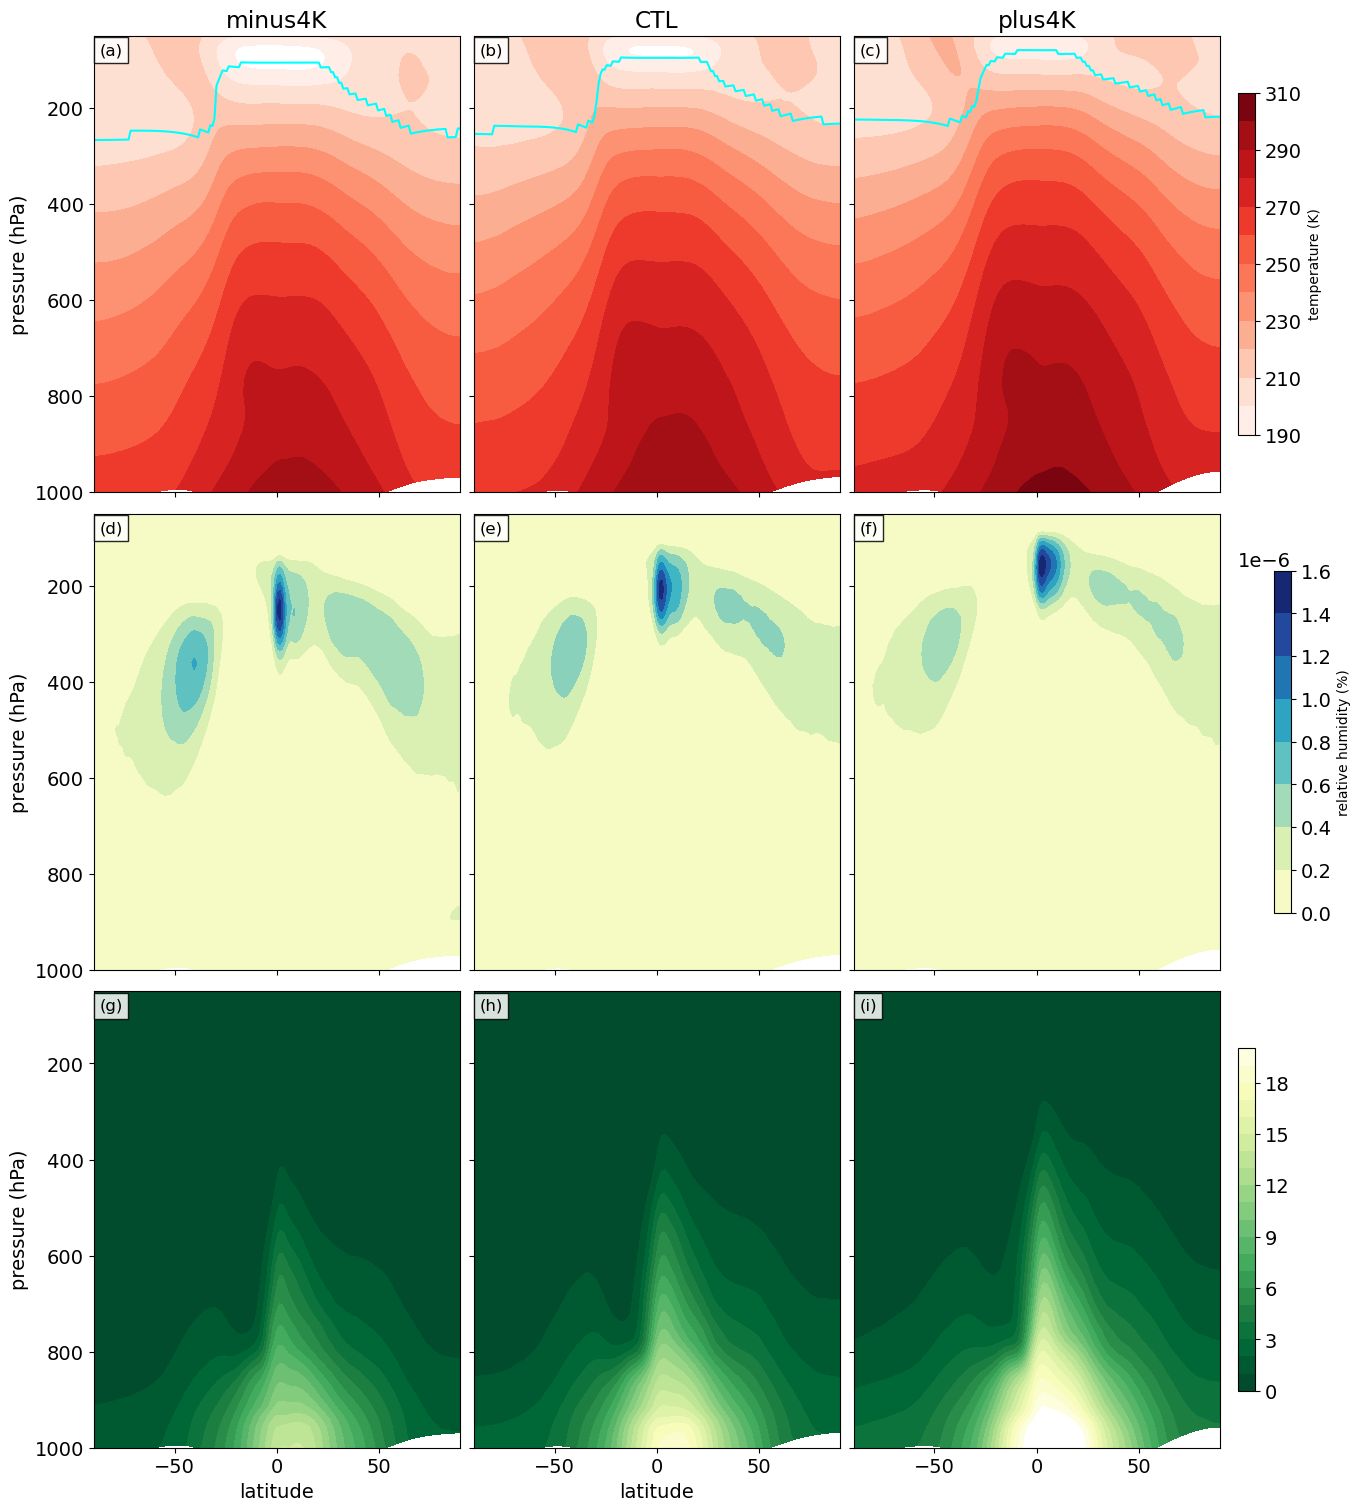

In [45]:
fig, ax = plt.subplots(nrows=3,ncols=nexps,figsize=(4.5*nexps,15),sharex=True,sharey=True,constrained_layout=True)

for i in np.arange(nexps):
    expName = list_of_exps[i]
    print(expName)

    # read in model fields
    fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
    ds = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).squeeze()
    taModel = ds.temperature.mean('lon')
    qvModel = ds.qv.mean('lon')
    zModel = ds.level
    mseModel = 1004.1*taModel + 2.5e6*qvModel + 9.81*zModel
    # fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180.nc'
    # plev = xr.open_dataset(fname3d)['pressure'].sel(lat=slice(uaModel.lat.min(),uaModel.lat.max())).isel(time=-1).mean(dim=('lon'))
    plev = ds.pressure.mean('lon')
    qcModel = ds.qi.mean('lon')#(ds.qc+ds.qi+ds.qg+ds.qs+ds.qr).mean('lon')
    print(qcModel.min(),qcModel.max())

    #get tropopause height
    tropHeightK, tropHeightP = get_tropopause_height_ptgt(taModel,plev)
    
    #calculate RH the same way it's calculated in the model
    qvs_v = RSLF(ds.pressure,ds.temperature)
    # qvs_i = RSIF(ds.pressure,ds.temperature)
    # qvs_v = qvs_v.where(ds.temperature > 273.15,qvs_i)
    rhModel = (ds.qv/qvs_v).squeeze().mean('lon')*100.0
    sdModel = (qvs_v-ds.qv).squeeze().mean('lon')*1e3
    print(qvModel.min().values,qvModel.max().values)
    print(qvs_v.min().values,qvs_v.max().values)
    print(sdModel.min().values,sdModel.max().values)
    
    # plot!
    # --- first plot: temperature ----- #
    [X,dummy] = np.meshgrid(taModel.lat,plev.mean('lat')*1.0e-2)
    cf1=ax[0,i].contourf(X,plev.T*1.0e-2,taModel.T,cmap='Reds',levels=np.arange(190,320,10))
    # add tropopause height
    ax[0,i].plot(taModel.lat,tropHeightP,color='cyan')
    ax[0,i].set_ylim([1000,50])
    ax[0,i].set_title(expLabels[expName])

    #---- second plot: rh? qv? 
    # cf2=ax[1,i].contourf(X,plev.T*1.0e-2,rhModel.T,cmap='YlGnBu',levels=np.arange(0,105,5))
    cf2=ax[1,i].contourf(X,plev.T*1.0e-2,qcModel.T,cmap='YlGnBu')#,levels=np.logspace(-6,-3,21),\
                         #norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))
    ax[1,i].set_ylim([1000,50])
    

    #  --- third plot: ...
    cf3=ax[2,i].contourf(X,plev.T*1.0e-2,1000*qvModel.T,cmap='YlGn_r',levels=np.linspace(0.0,20.,21))
    ax[2,i].set_ylim([1000,50])
    # break

# specify y-tick marks
# ax[-1,1].set_xticks([-10,0,10,20,30,40])
# ax[-1,1].set_xticklabels(['10S','0','10N','20N','30N','40N'])
# ax[-1,1].set_xlim([-10,40])
# add axis labels
ax[-1,0].set_xlabel('latitude')
ax[-1,1].set_xlabel('latitude')
# ax[-1,2].set_xlabel('latitude')
ax[0,0].set_ylabel('pressure (hPa)')
ax[1,0].set_ylabel('pressure (hPa)')
ax[2,0].set_ylabel('pressure (hPa)')
        
# add colorbars
cb1=fig.colorbar(cf1, ax=ax[0,-1], orientation="vertical",shrink=0.75)   
cb1.set_label('temperature (K)',fontsize=10)
cb2=fig.colorbar(cf2, ax=ax[1,-1], orientation="vertical",shrink=0.75)   
cb2.set_label('relative humidity (%)',fontsize=10)
cb3=fig.colorbar(cf3, ax=ax[2,-1], orientation="vertical",shrink=0.75)   
# cb3.set_label('saturation fraction (g kg$^{-1}$)',fontsize=10)

#add panel labels
# labels = ['(a)','(b)','(c)','(d)','(e)','(f)']
for i,axis in enumerate(ax.flat):
    label = "("+chr(i+97)+")"
    axis.text(0.015, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))

# plt.savefig('./Figures/mpas_aqua_sstmax10N_gencirc_comparison_thermodynamics_ASD.jpeg',bbox_inches='tight')

### Dynamics

60.84415817260742
6.726272106170654
69.05975341796875
6.552914619445801
73.48941802978516
6.899531364440918


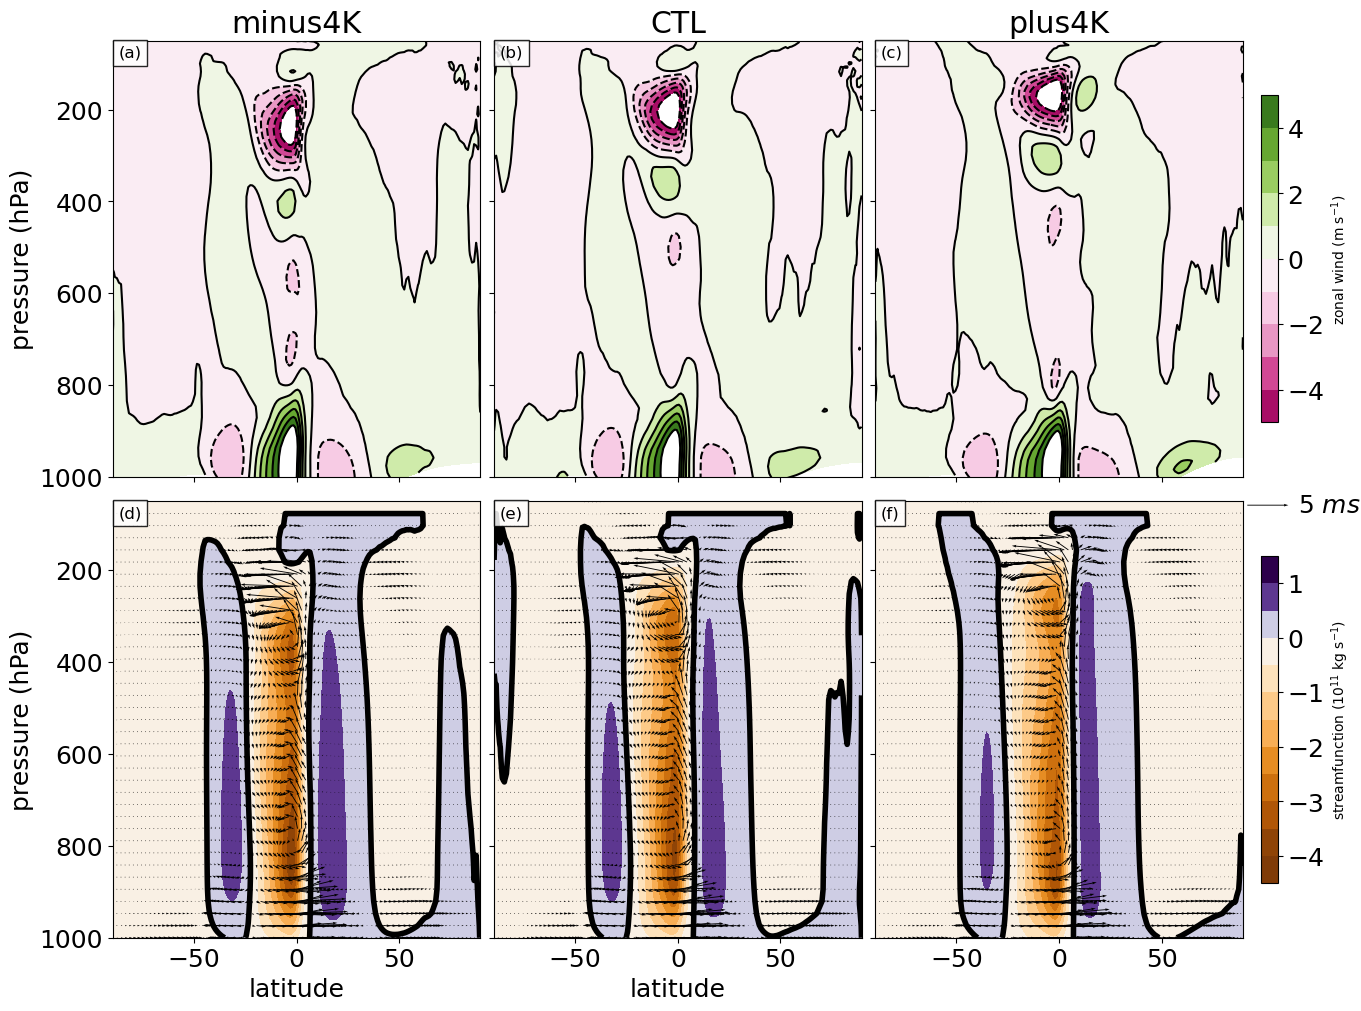

In [35]:
fig, ax = plt.subplots(nrows=2,ncols=nexps,figsize=(4.5*nexps,10),sharex=True,sharey=True,constrained_layout=True)

for i in np.arange(nexps):
    expName = list_of_exps[i]

    # read in model fields
    fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
    ds = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).squeeze()
    uaModel  = ds.uReconstructZonal.mean('lon')
    print(uaModel.max().values)
    vaModel  = ds.uReconstructMeridional.mean('lon')
    print(vaModel.max().values)
    waModel  = ds.w.squeeze().mean('lon')
    plev = ds.pressure.mean(dim=('lon'))
    
    # # calculate streamfunction
    # interpolate to isobaric surfaces
    p_int = np.linspace(50.0e2,1000.0e2, 37)
    va_isobaric = xr.DataArray(np.zeros((len(vaModel.lat),len(p_int))),\
                               coords=[vaModel.lat,p_int],\
                               dims=('lat','pressure'))
    wa_isobaric = va_isobaric.copy()
    for k in range(len(vaModel.lat)):
        p_old = plev[k,::-1]
        va_isobaric[k,:] = np.interp(p_int,p_old,vaModel[k,::-1])
        wa_isobaric[k,:] = np.interp(p_int,p_old,waModel[k,::-1])

    streamFunction = va_isobaric.copy()
    streamFunction[:,:] = 0.0
    mfac = (2.0*np.pi*Rearth*np.cos(np.radians(va_isobaric.lat))/G)
    for k in np.arange(1,len(p_int)):
        streamFunction[:,k] = mfac*np.trapz(va_isobaric[:,0:k],p_int[0:k],axis=1)

    
    # plot!
    # --- first plot: temperature + zonal wind ----- #
    [X,dummy] = np.meshgrid(uaModel.lat,plev.mean('lat')*1.0e-2)
    cf1=ax[0,i].contourf(X,plev.T*1.0e-2,vaModel.T,cmap='PiYG',levels=np.arange(-5,6,1))#,cmap='Reds',levels=np.arange(190,320,10))
    ax[0,i].contour(X,plev.T*1.0e-2,vaModel.T,levels=np.arange(-5,6),colors='k')
    ax[0,i].set_ylim([1000,50])
    ax[0,i].set_title(expLabels[expName])

    #  --- second plot: streamfunction  --- #
    # normalize the color map
    divnorm = colors.TwoSlopeNorm(vmin=-4., vcenter=0., vmax=1.0)
    # divnorm = colors.DivergingNorm(vmin=-1., vcenter=0., vmax=3.0)
    [Xsf,Ysf]=np.meshgrid(streamFunction.lat,streamFunction.pressure*1e-2)
    cf3=ax[1,i].contourf(Xsf,Ysf,streamFunction.T*1e-11,cmap='PuOr',levels=np.arange(-4.5,2.0,0.5),norm=divnorm)
    ax[1,i].contour(Xsf,Ysf,streamFunction.T,levels=[0],colors='k',linewidths=4)

    # add meridional overturning circulation
    vc1=ax[1,i].quiver(Xsf[::,::2],Ysf[::,::2],va_isobaric.T[::,::2],100*wa_isobaric.T[::,::2])
    ax[1,i].set_ylim([1000,50])
    # # --- third plot: rainfall  --- #
    # lp = ax[2,i].plot(prModel.lat,prModel*24.0,color='k',linewidth=4)
    # # ax[2,i].set_ylim([0.0,20.0])
    # ax[2,i].grid(True)

    
#add quiver legend
qk0 = ax[1,-1].quiverkey(vc1, 0.95, 0.50, 5, r'5 $ms^{-1}$', labelpos='E',
                   coordinates='figure')

# specify y-tick marks
# ax[-1,1].set_xticks([-10,0,10,20,30,40])
# ax[-1,1].set_xticklabels(['10S','0','10N','20N','30N','40N'])
# ax[-1,1].set_xlim([-10,40])
# add axis labels
ax[-1,0].set_xlabel('latitude')
ax[-1,1].set_xlabel('latitude')
# ax[-1,2].set_xlabel('latitude')
ax[0,0].set_ylabel('pressure (hPa)')
ax[1,0].set_ylabel('pressure (hPa)')
        
# add colorbars
cb1=fig.colorbar(cf1, ax=ax[0,-1], orientation="vertical",shrink=0.75)   
cb1.set_label('zonal wind (m s$^{-1})$',fontsize=10)
cb2=fig.colorbar(cf3, ax=ax[1,-1], orientation="vertical",shrink=0.75)   
cb2.set_label('streamfunction (10$^{11}$ kg s$^{-1}$)',fontsize=10)

#add panel labels
for i,axis in enumerate(ax.flat):
    label = "("+chr(i+97)+")"
    axis.text(0.015, 0.99, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))

# plt.savefig('./Figures/mpas_aqua_sstmax10N_gencirc_comparison_dynamics_ASD.jpeg',bbox_inches='tight')

### Difference plots

To improve the visualization of the differences, we'll plot CTL-minus4K and plus4K-CTL

In [36]:
# first read fields from each experiment
savedFields = {}
for i in np.arange(nexps):
    expName = list_of_exps[i]
    print(expName)
    
    # read in model fields
    fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
    ds = xr.open_dataset(fname3d).squeeze()
    ta = ds.temperature.squeeze().mean('lon')
    qv = ds.qv.squeeze().mean('lon')
    z = ds.level
    ua  = ds.uReconstructZonal.squeeze().mean('lon')
    va  = ds.uReconstructMeridional.squeeze().mean('lon')
    wa  = ds.w.squeeze().mean('lon')
    plev = ds.pressure.mean(dim=('lon'))
    #total condensate
    tc = (ds.qr+ds.qg+ds.qs+ds.qc+ds.qi).mean(dim=('lon'))

    #calculate RH the same way it's calculated in the model
    qvs_v = RSLF(ds.pressure,ds.temperature)
    # qvs_i = RSIF(ds.pressure,ds.temperature)
    # qvs_v = qvs_v.where(ds.temperature > 273.15,qvs_i)
    rh = (ds.qv/qvs_v).squeeze().mean('lon')*100.0
    sd = (qvs_v-ds.qv).squeeze().mean('lon')*1e3

    # interpolate to isobaric surfaces
    p_int = np.linspace(50.0e2,1000.0e2, 37)
    va_isobaric = xr.DataArray(np.zeros((len(va.lat),len(p_int))),\
                               coords=[va.lat,p_int],\
                               dims=('lat','pressure'))
    wa_isobaric = va_isobaric.copy()
    ua_isobaric = va_isobaric.copy()
    ta_isobaric = va_isobaric.copy()
    rh_isobaric = va_isobaric.copy()
    sd_isobaric = va_isobaric.copy()
    tc_isobaric = va_isobaric.copy()
    qv_isobaric = va_isobaric.copy()
    for k in range(len(va.lat)):
        p_old = plev[k,::-1]
        ua_isobaric[k,:] = np.interp(p_int,p_old,ua[k,::-1])
        va_isobaric[k,:] = np.interp(p_int,p_old,va[k,::-1])
        wa_isobaric[k,:] = np.interp(p_int,p_old,wa[k,::-1])
        ta_isobaric[k,:] = np.interp(p_int,p_old,ta[k,::-1])
        rh_isobaric[k,:] = np.interp(p_int,p_old,rh[k,::-1])
        sd_isobaric[k,:] = np.interp(p_int,p_old,sd[k,::-1])
        tc_isobaric[k,:] = np.interp(p_int,p_old,tc[k,::-1])
        qv_isobaric[k,:] = np.interp(p_int,p_old,qv[k,::-1])

    # # calculate streamfunction
    streamFunction = va_isobaric.copy()
    streamFunction[:,:] = 0.0
    mfac = (2.0*np.pi*Rearth*np.cos(np.radians(va_isobaric.lat))/G)
    for k in np.arange(1,len(p_int)):
        streamFunction[:,k] = mfac*np.trapz(va_isobaric[:,0:k],p_int[0:k],axis=1)
        
    # save the fields to a dictionary
    out = {
        'ua':ua_isobaric,
        'streamFunction':streamFunction,
        'va' : va_isobaric,
        'ta' : ta_isobaric,
        'rh' : rh_isobaric,
        'sd' : sd_isobaric,
        'wa' : wa_isobaric,
        'tc' : tc_isobaric,
        'qv' : qv_isobaric,
        'ta_hgt':ta, # to calculate tropopause level
        'prs_hgt':plev, # to calculate tropopause level
    }
    savedFields[expName] = out

minus4K
CTL
plus4K


In [ ]:
# # Temporary: save some fields interpolated to isobaric surfaces for KE
# for expName in list_of_exps:
#     ta = savedFields[expName]['ta']
#     qv = savedFields[expName]['qv']
#     ds = xr.Dataset(
#         data_vars=dict(
#             temperature=(["pressure", "lat"], ta.T.data, {'long_name':'temperature','units':'K'}),
#             qv=(["pressure","lat"], qv.T.data, {'long_name':'water vapor mixing ratio','units':'kg/kg'}),
#         ),
#         coords=dict(
#             lat=("lat", ta.lat.data,{'units':'degrees'}),
#             pressure=("pressure", ta.pressure.data,{'units':'Pa'})
#         ),
#         attrs=dict(description="Zonal-mean time-mean (180-days) data interpolated to isobaric surfaces and to a r360x180 regular grid."),
#     )
#     print(ds)
#     fOut = '/glade/derecho/scratch/rberrios/dataSharingASD/timemean_global_nospinup_r360x180_isobaric_%s.nc'%expName
#     ds.to_netcdf(fOut)

Now that we've read the fields and done some calculations, let's make difference plots

In [ ]:
def calc_wetbulb_temperature(ta,rh):
    return ta*np.arctan(0.151977*(rh+8.313659)**0.5) + np.arctan(ta+rh)-np.arctan(rh-1.676331)+\
      (0.00391838*(rh**(3./2.))*np.arctan(0.023101*rh))-4.686035

<xarray.DataArray ()> Size: 8B
array(-2.45543848) <xarray.DataArray ()> Size: 8B
array(3.06694379)
<xarray.DataArray ()> Size: 8B
array(-2.68312301) <xarray.DataArray ()> Size: 8B
array(3.56184293)
<xarray.DataArray ()> Size: 8B
array(-7.79454805e-08) <xarray.DataArray ()> Size: 8B
array(0.00445784)
<xarray.DataArray ()> Size: 8B
array(-7.35078191e-09) <xarray.DataArray ()> Size: 8B
array(0.00608706)


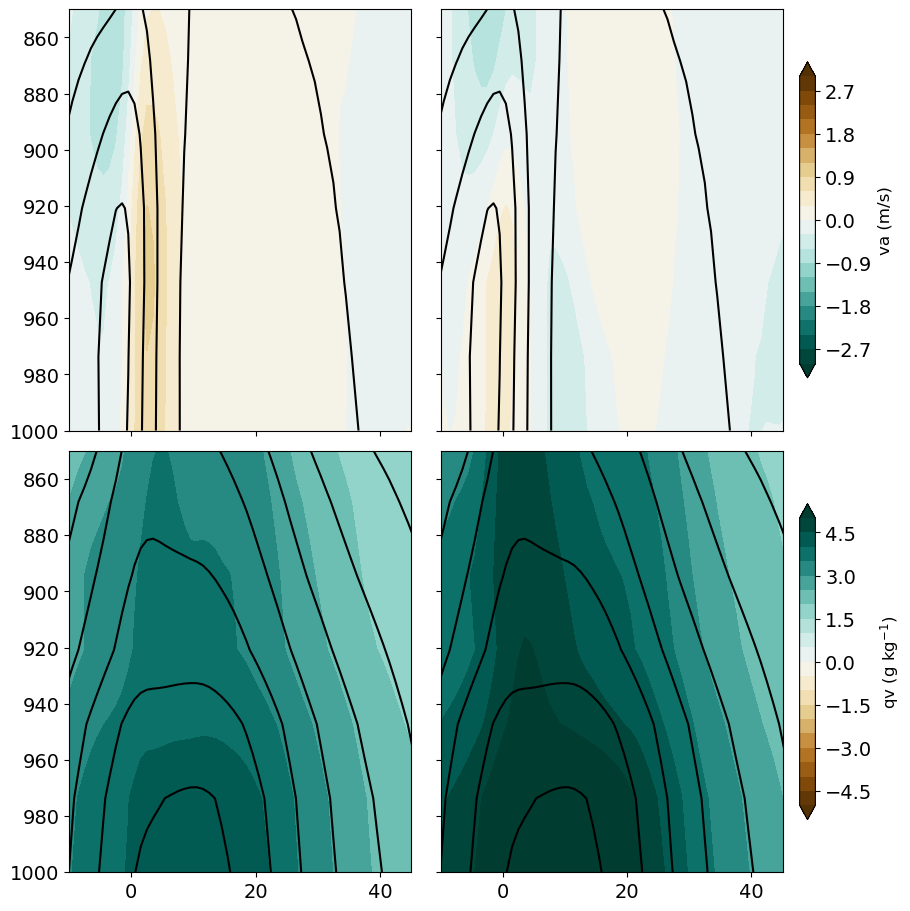

In [43]:
plt.rcParams.update({'font.size': 14})#font size
fig, ax = plt.subplots(nrows=2,ncols=nexps-1,figsize=(9,9),sharex=True,sharey=True,constrained_layout=True)

# --- first plot: saturation deficit -----#
sd = savedFields['CTL']['va']-savedFields['minus4K']['va']
print(sd.min(),sd.max())
[X,Y] = np.meshgrid(sd.lat,sd.pressure*1.0e-2)

cf1=ax[0,0].contourf(X,Y,sd.T,cmap='BrBG_r',levels=np.linspace(-3,3,21),extend='both')
ax[0,0].contour(X,Y,savedFields['CTL']['va'].T,colors='k',levels=np.linspace(0.0,20.,11))
ax[0,0].set_ylim([1000,850])
ax[0,0].set_xlim([-10,45])
# ----- plus4K minus CTL ----- #
sd = savedFields['plus4K']['va']-savedFields['CTL']['va']
print(sd.min(),sd.max())
ax[0,1].contourf(X,Y,sd.T,cmap='BrBG_r',levels=np.linspace(-3,3,21),extend='both')
ax[0,1].contour(X,Y,savedFields['CTL']['va'].T,colors='k',levels=np.linspace(0.0,20.,11))

# --- first plot: saturation deficit -----#
sd = savedFields['CTL']['qv']-savedFields['minus4K']['qv']
print(sd.min(),sd.max())
cf2=ax[1,0].contourf(X,Y,sd.T*1e3,cmap='BrBG',levels=np.linspace(-5,5,21),extend='both')
ax[1,0].contour(X,Y,savedFields['CTL']['qv'].T*1e3,colors='k',levels=np.linspace(0.0,20.,11))
ax[1,0].set_ylim([1000,850])
# ----- plus4K minus CTL ----- #
sd = savedFields['plus4K']['qv']-savedFields['CTL']['qv']
print(sd.min(),sd.max())
ax[1,1].contourf(X,Y,sd.T*1e3,cmap='BrBG',levels=np.linspace(-5,5,21),extend='both')
ax[1,1].contour(X,Y,savedFields['CTL']['qv'].T*1e3,colors='k',levels=np.linspace(0.0,20.,11))


# add colorbars
cb1=fig.colorbar(cf1, ax=ax[0,-1], orientation="vertical",shrink=0.75)   
cb1.set_label('va (m/s)',fontsize=12)
cb2=fig.colorbar(cf2, ax=ax[1,-1], orientation="vertical",shrink=0.75)   
# cb2.set_label('saturation deficit (g kg$^{-1}$)',fontsize=12)
cb2.set_label('qv (g kg$^{-1}$)',fontsize=12)


In [ ]:
plt.rcParams.update({'font.size': 14})#font size
fig, ax = plt.subplots(nrows=2,ncols=nexps-1,figsize=(9,9),sharex=True,sharey=True,constrained_layout=True)

# --- first plot: temperature ----- #
# --- CTL - minus4K --- #
ta = savedFields['CTL']['ta']-savedFields['minus4K']['ta']
[X,Y] = np.meshgrid(ta.lat,ta.pressure*1.0e-2)
cf1=ax[0,0].contourf(X,Y,ta.T,cmap='RdBu_r',levels=np.arange(-12,13,1))
# also plot CTL
cl1a=ax[0,0].contour(X,Y,savedFields['CTL']['ta'].T,colors='k',levels=np.arange(190,310,10))
# also plot the 0-C level
ax[0,0].contour(X,Y,savedFields['CTL']['ta'].T,colors=('cyan'),levels=[273.15],extend='both')
ax[0,0].contour(X,Y,savedFields['minus4K']['ta'].T,colors=('cyan'),levels=[273.15],linestyles='dashed')
# also plot the tropopause height
tropHeightK, tropHeightP_CTL = get_tropopause_height_ptgt(savedFields['CTL']['ta_hgt'],savedFields['CTL']['prs_hgt'])
print(tropHeightP_CTL.min())
ax[0,0].plot(ta.lat,tropHeightP_CTL,color='yellow')
tropHeightK, tropHeightP = get_tropopause_height_ptgt(savedFields['minus4K']['ta_hgt'],savedFields['minus4K']['prs_hgt'])
print(tropHeightP.min())
ax[0,0].plot(ta.lat,tropHeightP,color='yellow',linestyle='dashed')
ax[0,0].set_ylim([1000,50])
# --- plus4K - CTL --- #
ta = savedFields['plus4K']['ta']-savedFields['CTL']['ta']
[X,Y] = np.meshgrid(ta.lat,ta.pressure*1.0e-2)
ax[0,1].contourf(X,Y,ta.T,cmap='RdBu_r',levels=np.arange(-12,13,1))
# also plot CTL
cl1b=ax[0,1].contour(X,Y,savedFields['CTL']['ta'].T,colors='k',levels=np.arange(190,310,10),extend='both')
# also plot the melting level of both experiments
ax[0,1].contour(X,Y,savedFields['CTL']['ta'].T,colors=('cyan'),levels=[273.15])
ax[0,1].contour(X,Y,savedFields['plus4K']['ta'].T,colors=('cyan'),levels=[273.15],linestyles='dashed')
# also add the tropopause
ax[0,1].plot(ta.lat,tropHeightP_CTL,color='yellow')
tropHeightK, tropHeightP = get_tropopause_height_ptgt(savedFields['plus4K']['ta_hgt'],savedFields['plus4K']['prs_hgt'])
print(tropHeightP.min())
ax[0,1].plot(ta.lat,tropHeightP,color='yellow',linestyle='dashed')

# --- second plot: zonal wind ----- #
# --- CTL - minus4K --- #
ua = savedFields['CTL']['ua']-savedFields['minus4K']['ua']
[X,Y] = np.meshgrid(ua.lat,ua.pressure*1.0e-2)
cf2=ax[1,0].contourf(X,Y,ua.T,cmap='PiYG',levels=np.arange(-12,13,1),extend='both')
# also plot CTL
cl2a=ax[1,0].contour(X,Y,savedFields['CTL']['ua'].T,colors='k',levels=np.arange(-80,90,10))
ax[1,0].set_ylim([1000,50])
# --- plus4K - CTL --- #
ua = savedFields['plus4K']['ua']-savedFields['CTL']['ua']
ax[1,1].contourf(X,Y,ua.T,cmap='PiYG',levels=np.arange(-12,13,1),extend='both')
# also plot CTL
cl2b=ax[1,1].contour(X,Y,savedFields['CTL']['ua'].T,colors='k',levels=np.arange(-80,90,10))

# specify y-tick marks
ax[-1,1].set_xticks([-60,-30,0,30,60])
ax[-1,0].set_xticklabels(['60S','30S','0','30N','60N'])
ax[-1,1].set_xticklabels(['60S','30S','0','30N','60N'])
#ax[-1,1].set_xlim([-10,40])
# add axis labels
ax[-1,0].set_xlabel('latitude')
ax[-1,1].set_xlabel('latitude')
ax[0,0].set_ylabel('pressure (hPa)')
ax[1,0].set_ylabel('pressure (hPa)')
        
# add colorbars
cb1=fig.colorbar(cf1, ax=ax[0,-1], orientation="vertical",shrink=0.75)   
cb1.set_label('temperature (K)',fontsize=12)
cb2=fig.colorbar(cf2, ax=ax[1,-1], orientation="vertical",shrink=0.75)   
# cb2.set_label('saturation deficit (g kg$^{-1}$)',fontsize=12)
cb2.set_label('zonal wind (m s$^{-1}$)',fontsize=12)

#add panel labels
# labels = ['(a)','(b)','(c)','(d)','(e)','(f)']
for i,axis in enumerate(ax.flat):
    label = "("+chr(i+97)+")"
    axis.text(0.02, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))
#add titles
ax[0,0].set_title('CTL - minus4K')
ax[0,1].set_title('plus4K - CTL')

plt.savefig('./Figures/mpas_aqua_sstmax10N_gencirc_comparison_ta+ua_ASD.jpeg',bbox_inches='tight',dpi=600)

Repeat for saturation deficit and total condensate.

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=nexps-1,figsize=(9,9),sharex=True,sharey=True,constrained_layout=True)

# --- first plot: saturation deficit -----#
sd = savedFields['CTL']['sd']-savedFields['minus4K']['sd']
print(sd.min(),sd.max())
cf1=ax[0,0].contourf(X,Y,sd.T,cmap='BrBG_r',levels=np.linspace(-5,5,21),extend='both')
ax[0,0].contour(X,Y,savedFields['CTL']['sd'].T,colors='k',levels=np.linspace(0.0,20.,11))
ax[0,0].set_ylim([1000,50])
# ----- plus4K minus CTL ----- #
sd = savedFields['plus4K']['sd']-savedFields['CTL']['sd']
print(sd.min(),sd.max())
ax[0,1].contourf(X,Y,sd.T,cmap='BrBG_r',levels=np.linspace(-5,5,21),extend='both')
ax[0,1].contour(X,Y,savedFields['CTL']['sd'].T,colors='k',levels=np.linspace(0.0,20.,11))

# # --- second plot: condensate ----- #
# --- CTL - minus4K --- #
tc = savedFields['CTL']['tc']-savedFields['minus4K']['tc']
[X,Y] = np.meshgrid(tc.lat,tc.pressure*1.0e-2)
cf2=ax[1,0].contourf(X,Y,tc.T*1e5,cmap='RdGy',levels=np.linspace(-4.5,4.5,21),extend='both')
# also plot CTL
cl2a=ax[1,0].contour(X,Y,savedFields['CTL']['tc'].T,colors='magenta',levels=[3e-5])
# add the melting level, defined as the 0C wet-bulb temp
twb = calc_wetbulb_temperature(savedFields['CTL']['ta']-273.15,savedFields['CTL']['rh'])
ax[1,0].contour(X,Y,twb.T,levels=[0],colors='deepskyblue')
twb = calc_wetbulb_temperature(savedFields['minus4K']['ta']-273.15,savedFields['plus4K']['rh'])
ax[1,0].contour(X,Y,twb.T,levels=[0],colors='deepskyblue',linestyles='dashed')
ax[1,0].set_ylim([1000,50])
# --- plus4K - CTL --- #
tc = savedFields['plus4K']['tc']-savedFields['CTL']['tc']
ax[1,1].contourf(X,Y,tc.T*1e5,cmap='RdGy',levels=np.linspace(-4.5,4.5,21),extend='both')
# also plot CTL
cl2b=ax[1,1].contour(X,Y,savedFields['CTL']['tc'].T,colors='magenta',levels=[3e-5])
# add the melting level, defined as the 0C wet-bulb temp
twb = calc_wetbulb_temperature(savedFields['CTL']['ta']-273.15,savedFields['CTL']['rh'])
ax[1,1].contour(X,Y,twb.T,levels=[0],colors='deepskyblue')
twb = calc_wetbulb_temperature(savedFields['plus4K']['ta']-273.15,savedFields['plus4K']['rh'])
ax[1,1].contour(X,Y,twb.T,levels=[0],colors='deepskyblue',linestyles='dashed')

# # --- second plot: streamfunction ----- #
# sf = savedFields['CTL']['streamFunction']-savedFields['minus4K']['streamFunction']
# print(sf.min(),sf.max())
# cf2=ax[1,0].contourf(X,Y,sf.T*1e-11,cmap='PuOr',levels=np.linspace(-1.0,1.0,21),extend='both')
# ax[1,0].contour(X,Y,savedFields['CTL']['streamFunction'].T*1e-11,colors='k',levels=[-5.0,-4.0,-3.0,-2.0,-1.0,0.5,1.0])
# sf = savedFields['plus4K']['streamFunction']-savedFields['CTL']['streamFunction']
# ax[1,1].contourf(X,Y,sf.T*1e-11,cmap='PuOr',levels=np.linspace(-1.0,1.0,21),extend='both')
# ax[1,1].contour(X,Y,savedFields['CTL']['streamFunction'].T*1e-11,colors='k',levels=[-5.0,-4.0,-3.0,-2.0,-1.0,0.5,1.0])

# specify y-tick marks
ax[-1,1].set_xticks([-60,-30,0,30,60])
ax[-1,0].set_xticklabels(['60S','30S','0','30N','60N'],fontsize=14)
ax[-1,1].set_xticklabels(['60S','30S','0','30N','60N'],fontsize=14)
#ax[-1,1].set_xlim([-10,40])
# add axis labels
ax[-1,0].set_xlabel('latitude')
ax[-1,1].set_xlabel('latitude')
ax[0,0].set_ylabel('pressure (hPa)')
ax[1,0].set_ylabel('pressure (hPa)')
        
# add colorbars
cb1=fig.colorbar(cf1, ax=ax[0,-1], orientation="vertical",shrink=0.75)   
cb1.set_label('saturation deficit (g kg$^{-1}$)',fontsize=12)
cb2=fig.colorbar(cf2, ax=ax[1,-1], orientation="vertical",shrink=0.75)   
cb2.set_label('total condensate (10$^{-5}$ kg kg$^{-1}$)',fontsize=12)

#add panel labels
for i,axis in enumerate(ax.flat):
    label = "("+chr(i+97)+")"
    axis.text(0.02, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))

#add titles
ax[0,0].set_title('CTL - minus4K')
ax[0,1].set_title('plus4K - CTL')


plt.savefig('./Figures/mpas_aqua_sstmax10N_gencirc_comparison_sd+tc_ASD.jpeg',bbox_inches='tight',dpi=600)

Individual plots of the stream function.

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=nexps,figsize=(13.5,4.5),sharex=True,sharey=True,constrained_layout=True)

# normalize the color map
divnorm = colors.TwoSlopeNorm(vmin=-4.5, vcenter=0., vmax=1.5)
#get coordinates
[X,Y] = np.meshgrid(savedFields['minus4K']['streamFunction'].lat,savedFields['minus4K']['streamFunction'].pressure*1.0e-2)
cf1=ax[0].contourf(X,Y,savedFields['minus4K']['streamFunction'].T*1e-11,cmap='PuOr',levels=np.arange(-4.5,2.0,0.25),norm=divnorm)
ax[0].contour(X,Y,savedFields['minus4K']['streamFunction'].T*1e-11,colors='k',levels=[-0.25,0.25])
ax[1].contourf(X,Y,savedFields['CTL']['streamFunction'].T*1e-11,cmap='PuOr',levels=np.arange(-4.5,2.0,0.25),norm=divnorm)
ax[1].contour(X,Y,savedFields['CTL']['streamFunction'].T*1e-11,colors='k',levels=[-0.25,0.25])
ax[2].contourf(X,Y,savedFields['plus4K']['streamFunction'].T*1e-11,cmap='PuOr',levels=np.arange(-4.5,2.0,0.25),norm=divnorm)
ax[2].contour(X,Y,savedFields['plus4K']['streamFunction'].T*1e-11,colors='k',levels=[-0.25,0.25])
ax[0].set_ylim([1000,50])

#add reference line at 200 hPa
ax[0].axhline(y=200.0,color='red')
ax[1].axhline(y=200.0,color='red')
ax[2].axhline(y=200.0,color='red')


# # add colorbars
cb1=fig.colorbar(cf1, ax=ax[-1], orientation="vertical",shrink=0.75)
cb1.set_label('mass streamfunction (10$^{11}$ kg s$^{-1}$)',fontsize=12)

# specify y-tick marks
ax[-1].set_xticks([-60,-30,0,30,60])
ax[0].set_xticklabels(['60S','30S','0','30N','60N'],fontsize=14)
ax[1].set_xticklabels(['60S','30S','0','30N','60N'],fontsize=14)
ax[2].set_xticklabels(['60S','30S','0','30N','60N'],fontsize=14)
ax[0].set_xlim([-90,90])
# add axis labels
ax[0].set_xlabel('latitude')
ax[1].set_xlabel('latitude')
ax[2].set_xlabel('latitude')
ax[0].set_ylabel('pressure (hPa)')

#add panel labels
for i,axis in enumerate(ax.flat):
    label = "("+chr(i+97)+")"
    axis.text(0.015, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))

#add titles
ax[0].set_title('minus4K')
ax[1].set_title('CTL')
ax[2].set_title('plus4K')
plt.savefig('./Figures/mpas_aqua_sstmax10N_gencirc_comparison_streamfunction_ASD.jpeg',bbox_inches='tight',dpi=600)

### Vertical profiles averaged over the tropics

minus4K
0.0918004392163472
CTL
0.10495193052352621
plus4K
0.11969725484054


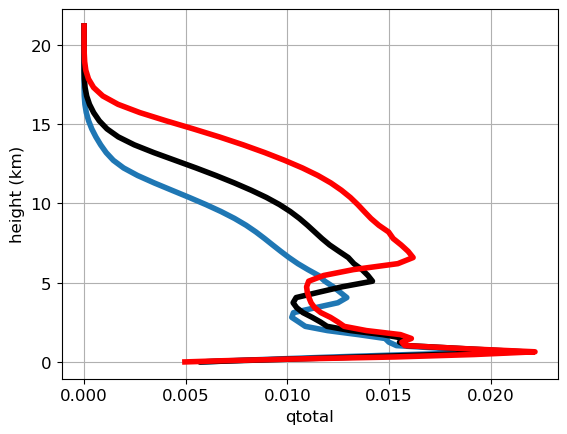

In [66]:
#increase font size
plt.rcParams.update({'font.size': 12})

lineColors = {
    'minus4K':'tab:blue',
    'CTL':'black',
    'plus4K':'red',
    'CTL/120km':'black',
    'HOMO_RAD' : 'purple',
    'HOMO_RAD/120km':'red',
    'HOMO_RAD/120km_online':'tab:orange',
    'HOMO_RAD/120km_from_restart' : 'tab:blue'}

varsInfo = {
    'qv': {'factor': 1e3, 'label': 'water vapor\n mixing ratio\n (g kg$^{-1}$)'},
    'temperature' : {'factor':1,'label':'temperature (K)'},
    'uReconstructZonal': {'factor':1,'label':'zonal wind (m s$^{-1}$)'},
    'uReconstructMeridional' : {'factor':1,'label':'meridional wind (m s$^{-1}$)'},
    'w': {'factor':1,'label':'vertical wind (m s$^{-1}$)'},
    'w+': {'factor':1,'label':'+ vertical wind (m s$^{-1}$)'},
    'qvs' : {'factor':1e3,'label':'saturated specific humidity (g kg$^{-1}$)'},
    'rh' : {'factor':1e2,'label':'relative humidity (%)'},
    'upward_qvs_flux' : {'factor':86400.0,'label':'wqvs (mm/day)'},
    'upward_qv_flux' : {'factor':86400.0,'label':'wqvs (mm/day)'},
    'pressure' : {'factor':1e-2,'label':'p (mb)'},
    'qi': {'factor':1.0e6,'label':'qi (10$^{-6}$ kg kg$^{-1}$)'},
    'qs': {'factor':1.0e3,'label':'qs'},
    'qc': {'factor':1.0e3,'label':'qc'},
    'qg': {'factor':1.0e3,'label':'qg'},
    'qr': {'factor':1.0e3,'label':'qr'},
    'qt':  {'factor':1.0e3,'label':'qtotal'},
}

plt.figure()

varName = 'qt'

for i in np.arange(nexps):
    expName = list_of_exps[i]
    print(expName)

    if (varName == 'qvs') | (varName == 'rh') | (varName == 'upward_qvs_flux'):
        # read in model fields
        fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
        ds = xr.open_dataset(fname3d).sel(lat=slice(0.5,3.5),level=slice(0,4e3))
        #calculate qvs the same way it's calculated in the model
        #calculate RH the same way it's calculated in the model
        qvs_v = RSLF(ds.pressure,ds.temperature)
        # qvs_i = RSIF(ds.pressure,ds.temperature)
        # qvs_v = qvs_v.where(ds.temperature > 273.15,qvs_i)
        if (varName == 'qvs'):
            ds[varName] = qvs_v.mean('time')
        elif (varName == 'rh'):
            ds[varName] = (ds.qv/qvs_v).mean('time')
        elif (varName == 'upward_qvs_flux'):
            w = ds.w
            w = w.where(w>0,0.0)
            qvs_v = qvs_v.where(w>0)
            ds[varName] = (w).mean('time')*(qvs_v).mean('time')
    elif (varName == 'upward_qv_flux'):
        # read in model fields
        fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
        ds = xr.open_dataset(fname3d).sel(lat=slice(0,5),level=slice(0,4e3))
        w = ds.w
        w = w.where(w>0,0.0)
        qv = ds.qv
        ds[varName] = (w*qv).mean('time')        
    elif (varName == 'w+'):
        # read in model fields
        fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
        ds = xr.open_dataset(fname3d).sel(lat=slice(0,20))
        w = ds.w
        w = w.where(w>0,0.0)
        ds[varName] = w.mean('time')
    elif (varName == 'qt'):
        # read in model fields
        fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
        ds = xr.open_dataset(fname3d).sel(lat=slice(-90,90))
        ds[varName] = ds.qc+ds.qs+ds.qi#+ds.qg
    else:
        # read in model fields
        fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
        ds = xr.open_dataset(fname3d).sel(lat=slice(-90,90))
            
    var = ds[varName].mean('lon').squeeze()
    # weight by cos of latitude
    coslat = np.cos(np.radians(var.lat))
    varAvg = (var*coslat).sum('lat')/coslat.sum('lat')
    print(np.trapz(varAvg*(ds.rhod.mean('lon')*coslat).sum('lat')/coslat.sum('lat'),varAvg.level))
    varAvg = varAvg*varsInfo[varName]['factor']
    plt.plot(varAvg,varAvg.level*1E-3,color=lineColors[expName],linewidth=4,label=expName)

    #get averaged precip
    fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
    pr = xr.open_dataset(fname2d).sel(lat=slice(0.5,3.5)).pr.mean('time').mean('lon')*24.0
    # plt.axvline(x=pr.mean(),color=lineColors[expName])

    # # compute absolute error to determine level to use
    # rmse = np.sqrt((pr.mean()-varAvg)**2.0)
    # print(rmse.idxmin(dim='level'))

plt.ylabel('height (km)')
plt.xlabel(varsInfo[varName]['label'])
plt.grid(True)
# plt.legend(True)
# plt.savefig('./Figures/comparison_globalAvg_%s.jpeg'%varName,bbox_inches='tight')

### Make panels of temperature changes

In [ ]:
fig, ax = plt.subplots(ncols=3,sharey=True,constrained_layout=True)

vars2plt = ['w','qvs','w+']

for j,axis in enumerate(ax.flat):
    varName = vars2plt[j]

    for i in np.arange(nexps):
        expName = list_of_exps[i]
    
        # read in model fields
        fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
        ds = xr.open_dataset(fname3d).sel(lat=slice(0,20),level=slice(0,5e3))
        if (varName == 'qvs') | (varName == 'rh'):
            #calculate qvs the same way it's calculated in the model
            #calculate RH the same way it's calculated in the model
            qvs_v = RSLF(ds.pressure,ds.temperature)
            # qvs_i = RSIF(ds.pressure,ds.temperature)
            # qvs_v = qvs_v.where(ds.temperature > 273.15,qvs_i)
            if (varName == 'qvs'):
                ds[varName] = qvs_v
            elif (varName == 'rh'):
                ds[varName] = ds.qv/qvs_v
        elif (varName == 'w+'):
            fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
            ds = xr.open_dataset(fname3d).sel(lat=slice(0,20),level=slice(0,5e3))            
            w = ds.w
            w = w.where(w>0.0)
            ds[varName]=w.mean('time')
        var = ds[varName].mean('lon').squeeze()
        # weight by cos of latitude
        coslat = np.cos(np.radians(var.lat))
        varAvg = (var*coslat).sum('lat')/coslat.sum('lat')
        varAvg = varAvg*varsInfo[varName]['factor']
        axis.plot(varAvg,varAvg.level*1E-3,color=lineColors[expName],linewidth=4)
    axis.set_xlabel(varsInfo[varName]['label'])
    axis.grid(True)

    # add panel labels
    label = "("+chr(j+97)+")"
    axis.text(0.97, 0.99, label,
        horizontalalignment='right',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))        

ax[0].set_ylabel('height (km)')
ax[1].legend(list_of_exps)
# plt.savefig('./Figures/vertical_profiles_0-20N_ASD.jpeg',dpi=600,bbox_inches='tight')

### Latitude profiles

In [19]:
# load module for inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#increase font size
plt.rcParams.update({'font.size': 12})

lineColors = {
    'minus4K':'tab:blue',
    'CTL':'gray',
    'plus4K':'red',
    'CTL/120km':'black',
    'HOMO_RAD' : 'purple',
    'HOMO_RAD/120km':'red',
    'HOMO_RAD/120km_online':'tab:orange',
    'HOMO_RAD/120km_from_restart' : 'tab:blue'}

varsInfo = {
    'qv': {'factor': 1e3, 'label': 'water vapor\n mixing ratio\n (g kg$^{-1}$)'},
    'temperature' : {'factor':1,'label':'temperature (K)'},
    'uReconstructZonal': {'factor':1,'label':'zonal wind (m s$^{-1}$)'},
    'uReconstructMeridional' : {'factor':1,'label':'meridional wind (m s$^{-1}$)'},
    'w': {'factor':1,'label':'vertical wind (m s$^{-1}$)'},
    'qvs' : {'factor':1e3,'label':'saturated specific humidity (g kg$^{-1}$)'},
    'rh' : {'factor':1e2,'label':'relative humidity (%)'},
    'mse' : {'factor': 1e-3, 'label' : 'moist static energy (kJ kg$^{-1}$)'},
    'vdvdy': {'factor':1.0,'label':'vdvdy'},
    'streamFunction_vavg':{'factor':1.0e-9,'label':'mass streamfunction (Gkg s$^{-1}$)'},
    'pr' : {'factor':24,'label':'rainfall rate (mm day$^{-1}$)'},
    'prc' : {'factor':24,'label':'param. rainfall rate (mm day$^{-1}$)'},
    'pr_resolved' : {'factor':24,'label':'res. rainfall rate (mm day$^{-1}$)'},
    'qfx': {'factor':2.5e6,'label':''},
    'hfx': {'factor':1.0,'label':''},
    'CRE': {'factor':1.0,'label':'cloud-radiative effect (W m$^{-2})$'},
    'CLEAR_SKY' : {'factor':1.0,'label':'clear-sky radiative flux '},
    'vh' : {'factor':1.0,'label':''},
    'wa100-300': {'factor':1,'label':'100--300 hPa vertical velocity (m s$^{-1}$)'},
    'energyFlux': {'factor':1.0e-15,'label':'energy transport (PW)'},
    'totalEnergyForcing' : {'factor':1.0,'label':'total energy forcing (W m$^{-1}$)'},
    'pr_from_qvflux' : {'factor':1.0,'label':'pr$_qvflux$ (mm/hr)'},
    'condensation_rate_vint': {'factor':1.0,'label':'COND'},
    'VI':{'factor':1.0,'label':'VI'},
    'CHI_TE': {'factor':1.0,'label':r'$\chi$'},
    'MPI_VMAX': {'factor':1.0,'label':'MPI (m s$^{-1}$)'},
    'SHRM':{'factor':1.0,'label':'200-850 hPa shear magnitude (m s$^{-1}$)'},
    'GPI_Emanuel':{'factor':1.0,'label':'GPI'},
    'absVOR850':{'factor':1.0e3,'label':'850-hPa absolute vorticity (10$^{-3}$ s$^{-1}$)'},
    'CHI_E':{'factor':1.0,'label':r'$\chi$'},
    'clwvi':{'factor':1.0,'label':'cloud water path (kg m$^{-2})$'},
    'clivi':{'factor':1.0,'label':'ice water path (kg m$^{-2})$'},
}

<xarray.DataArray 'pr' ()> Size: 4B
array(171040.19, dtype=float32)
<xarray.DataArray 'pr' ()> Size: 4B
array(201716.45, dtype=float32)
<xarray.DataArray 'pr' ()> Size: 4B
array(235296.98, dtype=float32)
<xarray.DataArray 'clwvi' ()> Size: 4B
array(5423.3604, dtype=float32)
<xarray.DataArray 'clwvi' ()> Size: 4B
array(6522.7676, dtype=float32)
<xarray.DataArray 'clwvi' ()> Size: 4B
array(7662.583, dtype=float32)
<xarray.DataArray 'clivi' ()> Size: 4B
array(3682.8428, dtype=float32)
<xarray.DataArray 'clivi' ()> Size: 4B
array(4104.8623, dtype=float32)
<xarray.DataArray 'clivi' ()> Size: 4B
array(4486.531, dtype=float32)


<Figure size 640x480 with 0 Axes>

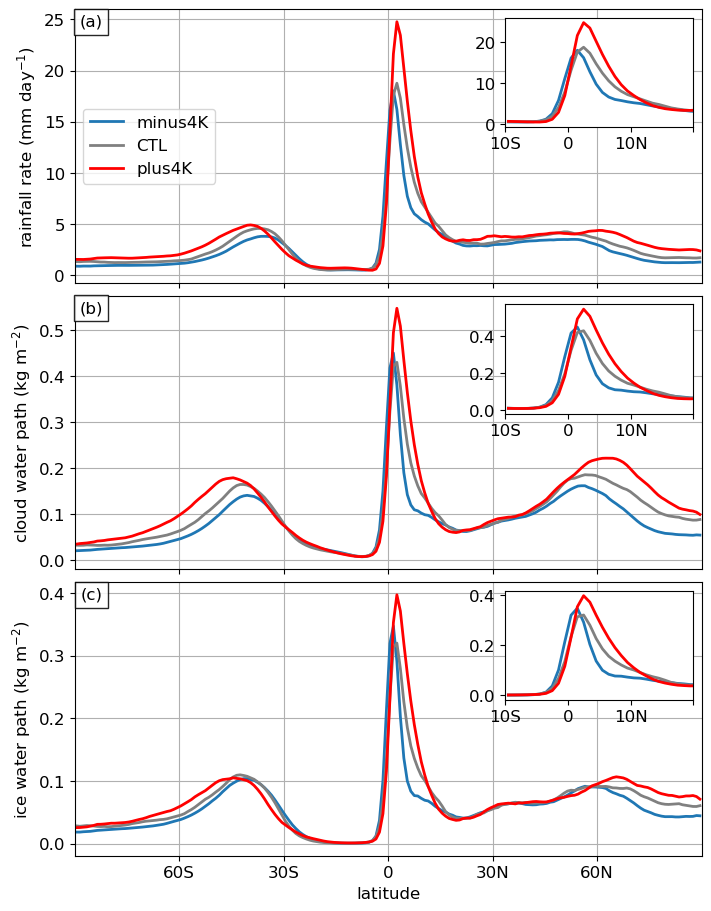

In [33]:
plt.figure()

level = 10.0

vars2plt = ['pr','clwvi','clivi']

fig, ax = plt.subplots(figsize=(7,len(vars2plt)*3),nrows=len(vars2plt),sharex=True,constrained_layout=True)

nexps=len(list_of_exps)
for j,axis in enumerate(ax.flat):
    varName = vars2plt[j]

    # Create inset of width 30% and height 40% of the parent Axes' bounding box
    # at the lower left corner.
    axins = inset_axes(axis, width="30%", height="40%", loc="upper right")

    for i in np.arange(nexps):
        expName = list_of_exps[i]
    
        # read in model fields
        fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
        # ds = xr.open_dataset(fname3d).sel(lat=slice(-10,45)).sel(level=level,method='nearest').squeeze()
        #print(xr.open_dataset(fname3d).pressure.sel(lat=0,lon=0,method='nearest').values)
        #continue
        if (varName == 'mse'):
            ds[varName] = ds.qv*2.5e6+ds.level*9.81+ds.temperature*1004.1
        elif (varName == 'vh'):
            fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180.nc'
            ds = xr.open_dataset(fname3d).sel(lat=slice(-45,45)).squeeze()
            mse = (ds.qv*2.5e6)+(ds.level*9.81)+(ds.temperature*1004.1)
            plev = ds.pressure
            #mse = mse.where( (plev<100e2) | (plev>1000e2))
            rhod = plev/(287.15*ds.temperature)
            dz = np.gradient(ds.level)
            # we also need the meridional wind and we need to vertically integrate
            va = ds.uReconstructMeridional
            var2int = (va*mse).mean('time').sum('lon')*(1.0*np.pi/180.0)/(2*np.pi)
            fig=plt.figure()
            plt.contourf(var2int.T)
            plt.colorbar()
            display(fig)
            dp = np.gradient(plev.mean('lon').mean('time'),axis=-1)
            var2int = -1.0*var2int*dp/9.81
            ds[varName] = xr.DataArray(var2int.sum('level'),coords=[ds.lat],dims=('lat'))
            
        #print((var2int*dz).sum('level'))
            #fig=plt.figure()
            #plt.plot((var2int*dz).sum('level'))
            #display(fig)
            #print('THIS CODE IS BROKEN')
            #break
            #ds[varName] = xr.DataArray(np.trapz(var2int,ds.level,axis=1),coords=[ds.lat],dims=('lat'))
            #print(flux)
            #plt.figure()
            #plt.plot(ds.lat,flux)
            #Rearth = 6371e3
            #transport = np.zeros((flux.shape))
            #weight = 2.0*np.pi*(Rearth)**2.0
            #for k in np.arange(1,len(ds.lat)):
     #           transport[k]=weight*np.cos(np.radians(ds.lat[k]))*np.trapz(flux[0:k],np.radians(ds.lat[0:k]))
            #ds[varName] = xr.DataArray(transport,coords=[ds.lat],dims=('lat'))
            #plt.figure()
            #plt.plot(ds.lat,ds[varName])
            #break
        elif (varName == 'vdvdy'):
            Rearth = 6371e3
            dvdy = np.gradient(ds.uReconstructMeridional,np.radians(ds.lat)*Rearth,axis=0)
            ds[varName] = ds.uReconstructMeridional*dvdy
        elif (varName == 'qvs') | (varName == 'rh'):
            #calculate qvs the same way it's calculated in the model
            #calculate RH the same way it's calculated in the model
            qvs_v = RSLF(ds.pressure,ds.temperature)
            qvs_i = RSIF(ds.pressure,ds.temperature)
            qvs_v = qvs_v.where(ds.temperature > 273.15,qvs_i)
            if (varName == 'qvs'):
                ds[varName] = qvs_v
            elif (varName == 'rh'):
                ds[varName] = ds.qv/qvs_v
        elif (varName == 'streamFunction_vavg'):
            # get streamfunction
            fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
            vaModel  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).uReconstructMeridional.squeeze().mean('lon')
            zModel = vaModel.level
            # mseModel = 1004.1*taModel + 2.5e6*qvModel + 9.81*zModel
            # del(qvModel,taModel)
            # waModel  = ds.w.squeeze().mean('lon')
            plev = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).pressure.squeeze().mean('lon')
            # interpolate to isobaric surfaces
            p_int = np.linspace(50.0e2,1000.0e2, 37)
            va_isobaric = xr.DataArray(np.zeros((len(vaModel.lat),len(p_int))),\
                                       coords=[vaModel.lat,p_int],\
                                       dims=('lat','pressure'))
            for k in range(len(vaModel.lat)):
                p_old = plev[k,::-1]
                va_isobaric[k,:] = np.interp(p_int,p_old,vaModel[k,::-1])

            streamFunction = va_isobaric.copy()
            streamFunction[:,:] = 0.0
            mfac = (2.0*np.pi*Rearth*np.cos(np.radians(va_isobaric.lat))/G)
            for k in np.arange(1,len(p_int)):
                streamFunction[:,k] = mfac*np.trapz(va_isobaric[:,0:k],p_int[0:k],axis=1)
            # zero out anything outside 300-700 mb
            ds[varName] = streamFunction.sel(pressure=slice(300e2,700e2)).mean('pressure')
            print(ds[varName].min())
        elif (varName == 'wa100-300'):
            fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
            waModel  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).w.squeeze().mean('lon')
            # scale to cm per s
            waModel = waModel*100.0
            plev = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).pressure.squeeze().mean('lon')
            # interpolate to 500 mb
            p_int = np.linspace(100.0e2,1000.0e2, 37)
            wa_isobaric = xr.DataArray(np.zeros((len(waModel.lat),len(p_int))),\
                                       coords=[waModel.lat,p_int],dims=('lat','pressure'))
            for k in range(len(wa_isobaric.lat)):
                p_old = plev[k,::-1]
                wa_isobaric[k,:] = np.interp(p_int,p_old,waModel[k,::-1])
            temp = wa_isobaric.sel(pressure=slice(100e2,300e2)).mean('pressure')
            ds[varName] = temp
        elif (varName == 'energyFlux') | (varName == 'totalEnergyForcing'):
            fname = '/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/%s/TC_3km/latlon/radFluxes_r360x180.nc'%expName
            ds = xr.open_dataset(fname)
            E, H, znetclr_atm, znetcf_atm, netsw, netlw, znet_atm = compute_mse_budget(ds)
            total = E+H+znet_atm
            if (varName == 'totalEnergyForcing'):
                # we summed over latitude; need to divide by number of points to get the zonal mean
                ds[varName] = total/(len(ds.lon))
            else:
                total = total-total.mean()
                transport = total.copy()
                transport[:] = 0.0
                dlat = np.radians(np.fabs(ds.lat[1]-ds.lat[0]))
                dlon = np.radians(np.fabs(ds.lon[1]-ds.lon[0]))
                weight = (dlat*dlon*Rearth**2.0) 
                for k in np.arange(1,len(total)):
                    transport[k]=weight*total[0:k].sum()
                ds[varName] = transport
        elif (varName == 'pr_from_qvflux'):
            fname=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
            ds = xr.open_dataset(fname).sel(lat=slice(-10,45))
            w = ds.w.sel(level=2000,method='nearest')
            print(w.min().values,w.max().values)
            qv = ds.qv.sel(level=2000,method='nearest')
            print(qv.min().values,qv.max().values)
            w = w.where(w>0)
            qv = qv.where(qv>0)
            # assume constant precip efficiency for now
            ep=0.9
            ds[varName] = (ep*qv*w).mean('time')#*1000.0*3600.0 # convert to mm/hr
        elif (varName == 'condensation_rate_vint') | (varName == 'PE'):
            fname=pth+expName+'/TC_3km/latlon/condensation_rate_r360x180.nc'
            ds = xr.open_dataset(fname).sel(lat=slice(-10,45))
            if (varName == 'PE'):
                fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
                pr = xr.open_dataset(fname2d).pr.sel(lat=slice(-10,45)).mean('time')
                ds[varName] = (condensation_rate.mean('time')/(pr/3600.0))
            else:
                ds[varName] = condensation_rate.mean('time')
        elif (varName == 'qfx') | (varName == 'hfx') | (varName == 'CRE') | (varName == 'CLEAR_SKY'):
            fname2d=pth+expName+'/TC_3km/latlon/radFluxes_r360x180.nc'
            ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
            if (varName == 'CLEAR_SKY'):
                ###clear-air tendencies
                zlwclr_top = -(ds.lwuptc)
                zswclr_top = (ds.swdnt-ds.swuptc)
    
                zlwclr_sfc = ((ds.lwdnbc-ds.lwupbc))
                zswclr_sfc = ((ds.swdnbc-ds.swupbc))
                znetclr_sfc = zlwclr_sfc + zswclr_sfc
    
                znetclr_top = zlwclr_top + zswclr_top
                # znetclr_top = zswclr_top
                znetclr_sfc = zlwclr_sfc + zswclr_sfc
                ds[varName] = (znetclr_top - znetclr_sfc).mean('time')
            elif (varName == 'CRE'):
                zlwcf_top = (ds.lwuptc - ds.olrtoa)
                zswcf_top = (ds.swuptc - ds.swupt)
    
                zlwcf_sfc = ((ds.lwdnb-ds.lwupb) - (ds.lwdnbc-ds.lwupbc))
                zswcf_sfc = ((ds.swdnb-ds.swupb) - (ds.swdnbc-ds.swupbc))
    
                znetcf_top = zlwcf_top + zswcf_top
                znetcf_sfc = zlwcf_sfc + zswcf_sfc
                ds[varName] = (znetcf_top - znetcf_sfc).mean('time')
            else:
                ds[varName] = xr.open_dataset(fname2d).sel(lat=slice(-10,45))[varName].mean('time')
        elif (varName == 'GPI_Emanuel'):
            print('calculating from the time mean conditions')
            fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
            ds = xr.open_dataset(fname2d).sel(lat=slice(-90,90))
            MPI = ds.MPI_VMAX-35.0
            MPI_tm = MPI.where(MPI>0.0,0.0).mean('time')
            CHI = ds.CHI_E.mean('time')
            VOR = ds.VOR850.mean('time')
            VOR = VOR+(2.0*7.292e-5*np.sin(np.radians(ds.lat)))
            SHR = (ds.SHRM+25.0).mean('time')
            GPI = (np.fabs(VOR)**3.0)*(CHI**(-4.0/3.0))*(MPI_tm**2.0)/(25.0+SHR)**4.0  
            # multiply by area 
            dlat=ds.lat[-1]-ds.lat[-2]
            dlon=ds.lon[1]-ds.lon[0]
            ds[varName] = GPI.sum('lon')*2.0*np.pi*np.cos(np.radians(ds.lat))*np.radians(dlat)*np.radians(dlon)*Rearth**2.0
            print(ds[varName].sum())
        elif (varName =='absVOR850'):
            fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
            ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
            VOR = ds.VOR850
            VOR = VOR+(2.0*7.292e-5*np.sin(np.radians(ds.lat)))
            ds[varName] = VOR.mean('time')
        elif (varName == 'pr_resolved'):
            fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
            ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
            ds[varName] = (ds.pr-ds.prc).mean('time')
        elif (varName == 'clwvi'):
            fname2d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
            ds = xr.open_dataset(fname2d).sel(lat=slice(-90,90))
            qc = ds.qc+ds.qi+ds.qs
            rhod = ds.rhod
            clwvi = xr.DataArray(np.trapz(qc*rhod,ds.level,-1),coords=[qc.time,qc.lat,qc.lon],dims=('time','lat','lon'))
            ds[varName]=clwvi.mean('time')
        elif (varName == 'clivi'):
            fname2d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
            ds = xr.open_dataset(fname2d).sel(lat=slice(-90,90))
            qc = ds.qi+ds.qs
            rhod = ds.rhod
            clivi = xr.DataArray(np.trapz(qc*rhod,ds.level,-1),coords=[qc.time,qc.lat,qc.lon],dims=('time','lat','lon'))
            ds[varName]=clivi.mean('time')
        else:
            fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
            ds = xr.open_dataset(fname2d).sel(lat=slice(-90,90))
            ds[varName] = ds[varName].mean('time')
        ds[varName] = ds[varName]*varsInfo[varName]['factor']
        print(ds[varName].sum())

        # print(ds[varName].sel(lat=0,method='nearest').mean('lon'))

        if (varName == 'streamFunction_vavg') | (varName == 'vh') | (varName == 'wa100-300') | \
           (varName == 'energyFlux') | (varName == 'totalEnergyForcing') | (varName == 'GPI_Emanuel'):
            axis.plot(ds.lat,ds[varName],color=lineColors[expName],linewidth=2)
        else:
            axis.plot(ds.lat, ds[varName].mean('lon').squeeze(), color=lineColors[expName], linewidth=2)
            # add inset zooming in the tropics
            varInset = ds[varName].sel(lat=slice(-10,25)).mean('lon')
            axins.plot(varInset.lat, varInset, color=lineColors[expName],linewidth=2)

    axis.set_ylabel(varsInfo[varName]['label'])
    axis.grid(True)
    if (varName == 'VI'):
        axis.set_yscale('log')

    # add panel labels
    label = "("+chr(j+97)+")"
    axis.text(0.045, 0.982, label,
        horizontalalignment='right',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))

    # add tick marks to the inset
    axins.set_xticks([-10,0,10,20])
    axins.set_xticklabels(['10S','0','10N',''])
    axins.set_xlim([-10,20])

# specify y-tick marks
# ax[-1].set_xticks([-10,0,10,20,30,40])
# ax[-1].set_xticklabels(['10S','0','10N','20N','30N','40N'])
# ax[-1].set_xlim([-10,45])
ax[-1].set_xticks([-60,-30,0,30,60])
ax[-1].set_xticklabels(['60S','30S','0','30N','60N'])
ax[-1].set_xlim([-90,90])
ax[-1].set_xlabel('latitude')
# add legend
ax[0].legend(list_of_exps, loc='center left')

plt.savefig('./Figures/lat_profiles_mpas_aqua_sstmax10N_ASD_prandco.jpeg',dpi=600,bbox_inches='tight')

### Make a single plot as a function of latitude or sin(latitude)

<Figure size 640x480 with 0 Axes>

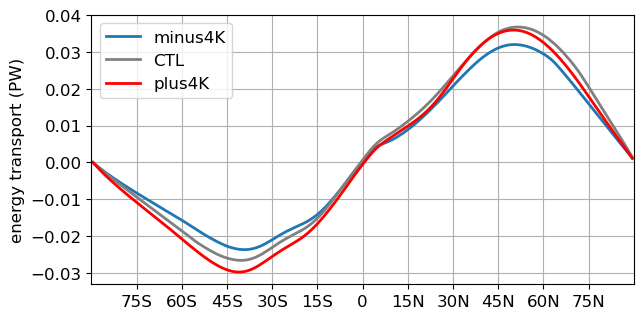

In [83]:
#increase font size
plt.rcParams.update({'font.size': 12})

# lineColors = {
#     'minus4K':'tab:blue',
#     'CTL':'gray',
#     'plus4K':'red',
#     'CTL/120km':'black',
#     'HOMO_RAD/120km':'red',
#     'HOMO_RAD/120km_online':'tab:orange',
#     'HOMO_RAD/120km_from_restart' : 'tab:blue',
#     'HOMO_RAD':'purple',
# }

# varsInfo = {
#     'MPI_VMAX': {'factor':1.0,'label':'MPI (m s$^{-1}$)'},
#     'SHRM':{'factor':1.0,'label':'200-850 hPa shear magnitude (m s$^{-1}$)'},
#     'GPI_Emanuel':{'factor':1.0,'label':'GPI'},
#     'absVOR850':{'factor':1.0,'label':'850-hPa absolute vorticity (s$^{-1}$)'},
#     'CHI_E':{'factor':1.0,'label':r'$\chi$'},
#     'prc':{'factor':24.0,'label':'param. precip'},
#     'pr':{'factor':24.0,'label':'rainfall rate (mm/day)'},
#     'pr_resolved':{'factor':24.0,'label':'resolved precip'},
#     'clwvi':{'factor':1.0,'label':'clwvi'},
# }

GPI_factors = {
    'minus4K': 147/0.0035649,#111/0.00390038,#3.95,
    'CTL': 147/0.0035649,#5.74,
    'plus4K': 147/0.0035649,#137/0.00392327,#4.67,
}

plt.figure()

level = 10.0

varName = 'energyFlux'

fig, axis = plt.subplots(figsize=(7,3.5))
list_of_exps=['minus4K','CTL','plus4K']
nexps=len(list_of_exps)
for i in np.arange(0,nexps):
    expName = list_of_exps[i]

    # read in model fields
    fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
    # ds = xr.open_dataset(fname3d).sel(lat=slice(-10,45)).sel(level=level,method='nearest').squeeze()
    #print(xr.open_dataset(fname3d).pressure.sel(lat=0,lon=0,method='nearest').values)
    #continue
    if (varName == 'GPI_Emanuel'):
        print('calculating from the time mean conditions')
        fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
        ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
        MPI = ds.MPI_VMAX-35.0
        MPI_tm = MPI.where(MPI>0.0,0.0).mean('time')
        CHI = ds.CHI_E.mean('time')
        VOR = ds.VOR850.mean('time')
        VOR = VOR+(2.0*7.292e-5*np.sin(np.radians(ds.lat)))
        SHR = (ds.SHRM+25.0).mean('time')
        GPI = (np.fabs(VOR)**3.0)*(CHI**(-4.0/3.0))*(MPI_tm**2.0)/(25.0+SHR)**4.0
        # multiply by area 
        dlat=ds.lat[-1]-ds.lat[-2]
        dlon=ds.lon[1]-ds.lon[0]
        scalingFactor=2.0*np.pi*np.cos(np.radians(ds.lat))*np.radians(dlon)*Rearth
        ds[varName] = GPI.sum('lon')*scalingFactor
        ds[varName] = ds[varName]*GPI_factors[expName]
        print((ds[varName]*np.radians(dlat)*Rearth).sum())
    elif (varName =='absVOR850'):
        fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
        ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
        VOR = ds.VOR850
        VOR = VOR+(2.0*7.292e-5*np.sin(np.radians(ds.lat)))
        ds[varName] = VOR.mean('time')
    elif (varName == 'pr_resolved'):
        fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r1440x720.nc'
        ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
        ds[varName] = (ds.pr-ds.prc).mean('time')
    elif (varName == 'streamFunction_vavg'):
        # get streamfunction
        fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
        vaModel  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).uReconstructMeridional.squeeze().mean('lon')
        zModel = vaModel.level
        # mseModel = 1004.1*taModel + 2.5e6*qvModel + 9.81*zModel
        # del(qvModel,taModel)
        # waModel  = ds.w.squeeze().mean('lon')
        plev = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).pressure.squeeze().mean('lon')
        # interpolate to isobaric surfaces
        p_int = np.linspace(50.0e2,1000.0e2, 37)
        va_isobaric = xr.DataArray(np.zeros((len(vaModel.lat),len(p_int))),\
                                   coords=[vaModel.lat,p_int],\
                                   dims=('lat','pressure'))
        for k in range(len(vaModel.lat)):
            p_old = plev[k,::-1]
            va_isobaric[k,:] = np.interp(p_int,p_old,vaModel[k,::-1])

        streamFunction = va_isobaric.copy()
        streamFunction[:,:] = 0.0
        mfac = (2.0*np.pi*Rearth*np.cos(np.radians(va_isobaric.lat))/G)
        for k in np.arange(1,len(p_int)):
            streamFunction[:,k] = mfac*np.trapz(va_isobaric[:,0:k],p_int[0:k],axis=1)
        #print(streamFunction.idxmin('pressure'))
        # zero out anything outside 300-700 mb
        ds[varName] = streamFunction.sel(pressure=slice(100e2,900e2)).mean('pressure')
        ds[varName].to_dataframe().to_csv('streamfunction_vavg_'+expName+'.csv')
    elif (varName == 'energyFlux') | (varName == 'totalEnergyForcing'):
        fname = '/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/%s/TC_3km/latlon/radFluxes_r360x180.nc'%expName
        ds = xr.open_dataset(fname)
        E, H, znetclr_atm, znetcf_atm, netsw, netlw, znet_atm = compute_mse_budget(ds)
        total = E+H+znet_atm
        if (varName == 'totalEnergyForcing'):
            # we summed over latitude; need to divide by number of points to get the zonal mean
            ds[varName] = total/(len(ds.lon))
        else:
            total = total-total.mean()
            transport = total.copy()
            transport[:] = 0.0
            dlat = np.radians(np.fabs(ds.lat[1]-ds.lat[0]))
            dlon = np.radians(np.fabs(ds.lon[1]-ds.lon[0]))
            weight = (dlat*dlon*Rearth**2.0)*len(ds.lon) # bc we too the zonal mean but for ttans
            for k in np.arange(1,len(total)):
                transport[k]=weight*total[0:k].sum()
            ds[varName] = transport
    elif (varName == 'clwvi'):
        fname2d=pth+expName+'/TC_3km/latlon/clwvi_including_qs.nc'
        ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
        ds[varName] = ds[varName].mean('time')        
    else:
        print('here')
        fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
        ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
        ds[varName] = ds[varName].mean('time')
    ds[varName] = ds[varName]*varsInfo[varName]['factor']

    # print(ds[varName].sel(lat=0,method='nearest').mean('lon'))

    if (varName == 'GPI_Emanuel'):
        axis.plot(np.sin(np.radians(ds.lat)),ds[varName],color=lineColors[expName],linewidth=2,\
                 label='%s (%i)'%(list_of_exps[i],np.ceil((ds[varName]*Rearth*np.radians(dlat)).sum())))
        axis.set_xlabel('sin(latitude)')
    elif (varName == 'streamFunction_vavg') | (varName == 'vh') | (varName == 'wa100-300') | \
       (varName == 'energyFlux') | (varName == 'totalEnergyForcing'):
        axis.plot(ds.lat,ds[varName],color=lineColors[expName],linewidth=2,label='%s'%expLabels[expName])
        axis.set_xticks([-75,-60,-45,-30,-15,0,15,30,45,60,75])
        axis.set_xticklabels(['75S','60S','45S','30S','15S','0','15N','30N','45N','60N','75N'])
        axis.set_xlim([-90,90])
    else:
        axis.plot(ds.lat,ds[varName].mean('lon').squeeze(),color=lineColors[expName],linewidth=2,label='%s'%expLabels[expName])
        axis.set_xlabel('latitude')
        # specify y-tick marks
        axis.set_xticks([-10,0,10,20,30,40])
        axis.set_xticklabels(['10S','0','10N','20N','30N','40N'])
        axis.set_xlim([-10,40])

    # add confidence intervals: daily min and max
    if (varName == 'pr'):
        fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
        ds = xr.open_dataset(fname2d).sel(lat=slice(-10,45))
        pr = ds.pr.mean('lon').resample(time='1M').mean()*varsInfo[varName]['factor']
        prmin = pr.min(dim='time')
        print(prmin)
        prmax = pr.max(dim='time')
        axis.fill_between(ds.lat, prmin, prmax, alpha=0.5, color=lineColors[expName])

axis.set_ylabel(varsInfo[varName]['label'])
axis.grid(True)
if (varName == 'VI'):
    axis.set_yscale('log')
# axis.axvline(x=2.5,color='k')

# add legend
axis.legend()
# plt.savefig('./Figures/lat_profiles_mpas_aqua_sstmax10N_ASD_%s.jpeg'%varName,dpi=600,bbox_inches='tight')

In [ ]:
# x1=np.array(-0.8714097e15)
# x2=np.array(-1.00486186e15)
# x3=np.array(-0.915135e15)

# y1=np.array(71.02693137)
# y2=np.array(68.19348349)
# y3=np.array(66.94148309)

# #testing...
# x1 = x1/(2.0*np.pi*Rearth)
# x2 = x2/(2.0*np.pi*Rearth)
# x3 = x3/(2.0*np.pi*Rearth)
# #formula = - energy flux / (Rearth * total energy forcing)
# lat1 = np.degrees(-x1/(Rearth*y1))
# lat2 = np.degrees(-x2/(Rearth*y2))
# lat3 = np.degrees(-x3/(Rearth*y3))
# lat1, lat2, lat3

### Get basic metrics of the ITCZ and Hadley cell

In [5]:
def get_itcz_metrics(expName,metricNames):
    " Reads lat-lon MPAS fields and calculates metrics of the ITCZ and Hadley cell."
    out = {}

    for metric in metricNames:
        if (metric == 'maxpr') | (metric=='maxpr_loc') | (metric=='pcent'):
            fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
            ds = xr.open_dataset(fname2d)
            pr = ds.pr.sel(lat=slice(-15,15)).mean('time').mean('lon')
            if (metric == 'maxpr'):
                out[metric] = pr.max()
            elif (metric=='maxpr_loc'):
                out[metric] = pr.idxmax()
            elif (metric=='pcent'):
                out[metric] = (pr*pr.lat).sum()/(pr.sum())
        elif (metric == 'itcz_strength_streamFunction') | (metric == 'itcz_width_streamFunction') |\
             (metric == 'itcz_loc_streamFunction') | (metric == 'itcz_area_streamFunction'):
            # get streamfunction
            fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
            vaModel  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).uReconstructMeridional.squeeze().mean('lon')
            zModel = vaModel.level
            plev  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).pressure.squeeze().mean('lon')
            # interpolate to isobaric surfaces
            p_int = np.linspace(50.0e2,1000.0e2, 37)
            va_isobaric = xr.DataArray(np.zeros((len(vaModel.lat),len(p_int))),\
                                       coords=[vaModel.lat,p_int],\
                                       dims=('lat','pressure'))
            for k in range(len(vaModel.lat)):
                p_old = plev[k,::-1]
                va_isobaric[k,:] = np.interp(p_int,p_old,vaModel[k,::-1])

            streamFunction = va_isobaric.copy()
            streamFunction[:,:] = 0.0
            mfac = (2.0*np.pi*Rearth*np.cos(np.radians(va_isobaric.lat))/G)
            for k in np.arange(1,len(p_int)):
                streamFunction[:,k] = mfac*np.trapz(va_isobaric[:,0:k],p_int[0:k],axis=1)
            # averaging only between select pressure levels
            streamFunction_vavg = streamFunction.sel(pressure=slice(300e2, 700e2)).mean('pressure')
            if (metric == 'itcz_strength_streamFunction'):
                area = 2.0*np.pi*(Rearth)**2.0*(np.sin(np.radians(streamFunction_vavg.idxmax()))-\
                                                       np.sin(np.radians(streamFunction_vavg.idxmin())))
                mass_transport=streamFunction_vavg.sel(lat=streamFunction_vavg.idxmax())-streamFunction_vavg.sel(lat=streamFunction_vavg.idxmin())
                print(area)
                print(mass_transport)
                out[metric]=(-G*mass_transport/area)
            elif (metric == 'itcz_width_streamFunction'):
                out[metric] = (streamFunction_vavg.idxmax())-(streamFunction_vavg.idxmin())
                print(streamFunction_vavg.idxmin(),streamFunction_
            elif (metric == 'itcz_loc_streamFunction'):
                temp=streamFunction_vavg.sel(lat=slice(-15,15))
                # # interpolate to 0.5 deg
                # # lat_int = np.linspace(-15,15,61)
                # streamFunction_vavg = temp.interp({'lat':lat_int})
                # negvals = np.where(streamFunction_vavg < 0)[0]
                # posvals = np.where(streamFunction_vavg >= 0)[0]
                # out[metric]=0.5*(streamFunction_vavg.lat[negvals[-1]].values+streamFunction_vavg.lat[posvals[0]].values)
                out[metric] = np.interp([0.0], temp, temp.lat) #streamFunction_vavg.sel(lat=slice(-15,15)).interp({'lat': 0.0})
            elif (metric == 'itcz_area_streamFunction'):
                out[metric] = 2.0*np.pi*(Rearth)**2.0*(np.sin(np.radians(streamFunction_vavg.idxmax()))-\
                                                       np.sin(np.radians(streamFunction_vavg.idxmin())))
        elif (metric == 'energyFluxEquator') | (metric == 'energyFlux_at_Equator'):
            ncfile = '/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/%s/TC_3km/latlon/radFluxes_r360x180.nc'%expName
            ds = xr.open_dataset(ncfile)
            E, H, znetclr_atm, znetcf_atm, netsw, netlw, znet_atm = compute_mse_budget(ds)
            total = E+H+znet_atm
            print(total.max())
            # remove the global mean
            weightForAvg = np.cos(np.radians(total.lat))
            globalAvg = (weightForAvg*total).sum()/(weightForAvg.sum())
            print(globalAvg)
            total = total-globalAvg
            # create new array
            transport_array = np.zeros(len(total))
            # weight
            dlat = np.radians(ds.lat[1]-ds.lat[0])
            dlon = np.radians(ds.lon[1]-ds.lon[0])
            weightForTransport = np.cos(np.radians(ds.lat))*Rearth*Rearth*dlat*dlon*len(ds.lon) #because we took the average along longitude
            # transport is the cumulative sum from the south pole until that latitude
            total = total*weightForTransport
            transport_array[1:] = total.cumsum()[0:-1]  # Improved vectorization
            transport = xr.DataArray(transport_array, dims=total.dims, coords=total.coords)

            if (metric == 'energyFluxEquator'):
                # negvals = np.where(transport < 0)[0]
                # posvals = np.where(transport >= 0)[0]
                # out[metric]=0.5*(transport.lat[negvals[-1]].values+transport.lat[posvals[0]].values)
                #fig = plt.figure()
                plt.plot(transport.lat, transport)
                display(fig)
                out[metric] = np.interp(0.0, transport.sel(lat=slice(-25,25)), transport.lat.sel(lat=slice(-25,25)))
            elif (metric == 'energyFlux_at_Equator'):
                out[metric] = np.interp([0.0], transport.lat, transport) #.sel(lat=0,method='nearest') #np.interp(temp.lat, [0.0], temp)
        elif (metric == 'wa100-300') | (metric == 'wa100-300_loc'):
            fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180.nc'
            waModel  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).w.squeeze().mean('lon')
            # scale to cm per s
            waModel = waModel*100.0
            plev = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).pressure.squeeze().mean('lon')
            # interpolate to 500 mb
            p_int = np.linspace(50.0e2,1000.0e2, 37)
            wa_isobaric = xr.DataArray(np.zeros((len(waModel.lat),len(p_int))),\
                                       coords=[waModel.lat,p_int],dims=('lat','pressure'))
            for k in range(len(wa_isobaric.lat)):
                p_old = plev[k,::-1]
                wa_isobaric[k,:] = np.interp(p_int,p_old,waModel[k,::-1])
            if (metric == 'wa500'):
                out[metric] = wa_isobaric.sel(pressure=500e2).max()
            elif (metric == 'wa500_loc'):
                out[metric] = wa_isobaric.sel(pressure=500e2).idxmax()
            elif (metric == 'wa100-300'):
                out[metric] = wa_isobaric.sel(pressure=slice(100e2,300e2)).mean('pressure').max()
            elif (metric == 'wa100-300_loc'):
                out[metric] = wa_isobaric.sel(pressure=slice(100e2,300e2)).mean('pressure').idxmax()

    return out

<xarray.DataArray ()> Size: 8B
array(71.02962494)
<xarray.DataArray ()> Size: 8B
array(8.89754126)
<xarray.DataArray ()> Size: 8B
array(71.02962494)
<xarray.DataArray ()> Size: 8B
array(8.89754126)


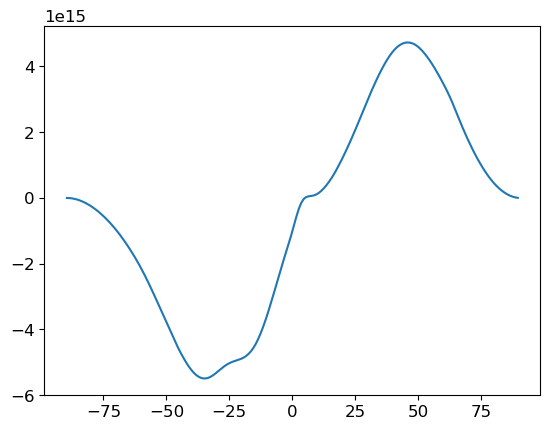

{'energyFlux_at_Equator': array([-1.00871855e+15]), 'energyFluxEquator': 5.039478014684927}
<xarray.DataArray ()> Size: 8B
array(72.87440491)
<xarray.DataArray ()> Size: 8B
array(10.2616825)
<xarray.DataArray ()> Size: 8B
array(72.87440491)
<xarray.DataArray ()> Size: 8B
array(10.2616825)


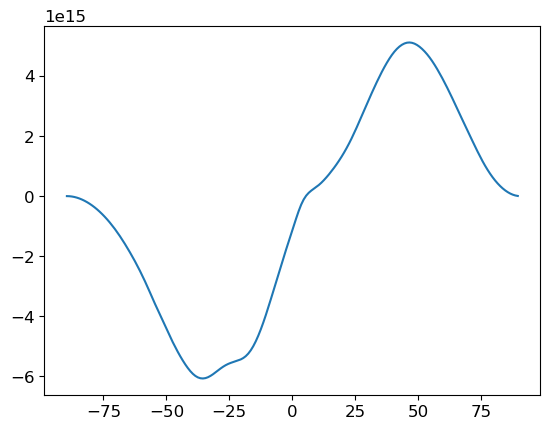

{'energyFlux_at_Equator': array([-1.13492699e+15]), 'energyFluxEquator': 5.3699735493528795}
<xarray.DataArray ()> Size: 8B
array(76.36515808)
<xarray.DataArray ()> Size: 8B
array(11.83510872)
<xarray.DataArray ()> Size: 8B
array(76.36515808)
<xarray.DataArray ()> Size: 8B
array(11.83510872)


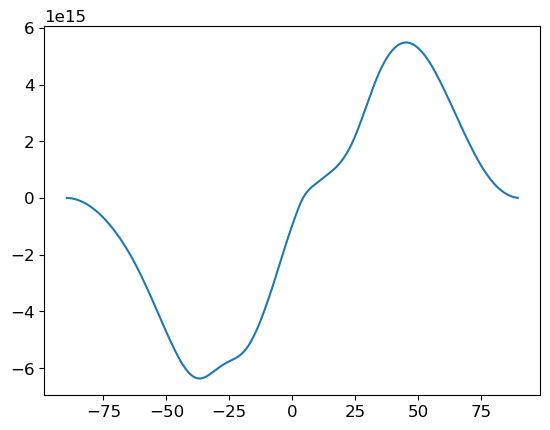

{'energyFlux_at_Equator': array([-9.49269335e+14]), 'energyFluxEquator': 4.244526423060481}


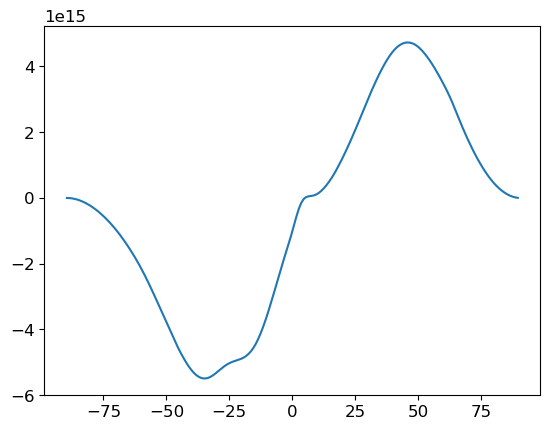

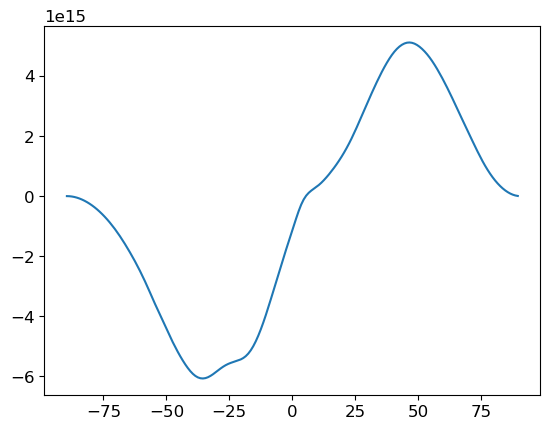

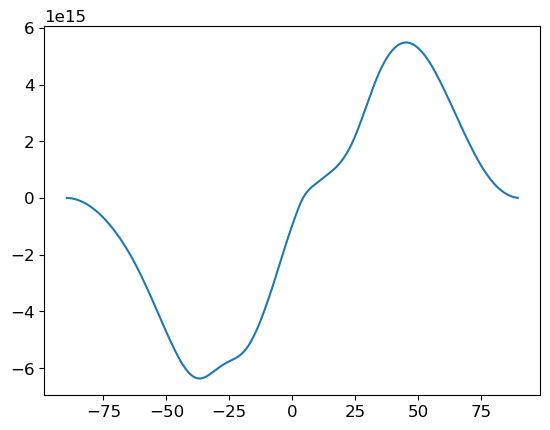

In [85]:
# metricNames = ['maxpr','maxpr_loc','pcent',\
#                'itcz_strength_streamFunction','itcz_loc_streamFunction','energyFluxEquator',\
#                'energyFlux_at_Equator','itcz_width_streamFunction','itcz_area_streamFunction',\
#               'wa100-300','wa100-300_loc']
metricNames = ['energyFlux_at_Equator', 'energyFluxEquator']
list_of_exps=['minus4K','CTL','plus4K']
metrics_per_exp = {}
for expName in list_of_exps:
    metrics = get_itcz_metrics(expName,metricNames)
    print(metrics)
    metrics_per_exp[expName] = metrics

Let's make some plots

In [ ]:
def get_linear_reg(x,y):
    
    # get linear regression
    # compute coefficients
    coefficients = np.polyfit(x, y, 1) 
    print(coefficients)
    # create a polynomial object with the coefficients
    polynomial = np.poly1d(coefficients)
    # create dummy x variable
    x_axis = np.linspace(np.min(x)-np.std(x),np.max(x)+np.std(x))
    # compute the y for each x using the polynomial
    y_axis = polynomial(x_axis)

    return [x_axis,y_axis]


fig, ax = plt.subplots(ncols=4,figsize=(12,4),sharey=True,constrained_layout=True)
x1=[]
x2=[]
x3=[]
x4=[]
y=[]
for expName in list_of_exps:
    y.append(metrics_per_exp[expName]['maxpr_loc'])
    x1.append(metrics_per_exp[expName]['energyFluxEquator'])
    x2.append(metrics_per_exp[expName]['energyFlux_at_Equator'])
    x3.append(metrics_per_exp[expName]['itcz_loc_streamFunction'])
    x4.append(metrics_per_exp[expName]['wa100-300_loc'])

    ax[0].plot(metrics_per_exp[expName]['energyFluxEquator'],metrics_per_exp[expName]['maxpr_loc'],'.',color=lineColors[expName],markersize=20)
    ax[1].plot(metrics_per_exp[expName]['energyFlux_at_Equator'],metrics_per_exp[expName]['maxpr_loc'],'.',color=lineColors[expName],markersize=20)
    ax[2].plot(metrics_per_exp[expName]['itcz_loc_streamFunction'],metrics_per_exp[expName]['maxpr_loc'],'.',color=lineColors[expName],markersize=20)
    ax[3].plot(metrics_per_exp[expName]['wa100-300_loc'],metrics_per_exp[expName]['maxpr_loc'],'.',color=lineColors[expName],markersize=20)
    
# lastly plot the fit
x_axis,y_axis = get_linear_reg(x1,y)
ax[0].plot(x_axis,y_axis,'--k')
ax[0].set_xlabel(r'energy flux equator ($^{\circ}$)')
x_axis,y_axis = get_linear_reg(x2,y)
ax[1].plot(x_axis,y_axis,'--k')
ax[1].set_xlabel(r'energy flux at the Eq. (PW)')
x_axis,y_axis = get_linear_reg(x3,y)
ax[2].plot(x_axis,y_axis,'--k')
ax[2].set_xlabel(r'lat. of $\Psi_{max}$ ($^{\circ}$)')
x_axis,y_axis = get_linear_reg(x4,y)
ax[3].plot(x_axis,y_axis,'--k')
ax[3].set_xlabel('lat. of max. $w_{100-300}$ ($^{\circ}$)')
ax[0].set_ylabel('lat. of max. rainfall rate ($^{\circ}$)')

for i,axis in enumerate(ax.flat):
    # add panel labels
    label = "("+chr(i+97)+")"
    axis.text(0.02, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 

plt.savefig('./Figures/comparison_maxpr_loc_vs_itcz_loc_metrics.jpeg',dpi=600,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(8,4),sharey=True,constrained_layout=True)
x1=[]
x2=[]
x3=[]
y=[]
for expName in list_of_exps:
    y.append(metrics_per_exp[expName]['maxpr']*24.)
    x1.append(metrics_per_exp[expName]['itcz_strength_streamFunction']*100.0)
    x2.append(metrics_per_exp[expName]['wa100-300'])

    ax[0].plot(metrics_per_exp[expName]['itcz_strength_streamFunction']*100.0,metrics_per_exp[expName]['maxpr']*24.,'.',color=lineColors[expName],markersize=20)
    ax[1].plot(metrics_per_exp[expName]['wa100-300'],metrics_per_exp[expName]['maxpr']*24.,'.',color=lineColors[expName],markersize=20)
    
# lastly plot the fit
x_axis,y_axis = get_linear_reg(x1,y)
ax[0].plot(x_axis,y_axis,'--k')
ax[0].set_xlabel(r'$\omega_{ITCZ}$ (hPa s$^{-1}$)')
x_axis,y_axis = get_linear_reg(x2,y)
ax[1].plot(x_axis,y_axis,'--k')
ax[1].set_xlabel(r'max $w_{100-300}$ ($m s^{-1}$)')
ax[0].set_ylabel('max. rainfall rate (mm day$^{-1}$)')

for i,axis in enumerate(ax.flat):
    # add panel labels
    label = "("+chr(i+97)+")"
    axis.text(0.015, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 

plt.savefig('./Figures/comparison_maxpr_vs_itcz_loc_metrics.jpeg',dpi=600,bbox_inches='tight')

Lastly, ITCZ width and area

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(8,4),sharey=True,constrained_layout=True)
x1=[]
x2=[]
x3=[]
y=[]
for expName in list_of_exps:
    y.append(metrics_per_exp[expName]['maxpr']*24.)
    x1.append(metrics_per_exp[expName]['itcz_width_streamFunction'])
    x2.append(metrics_per_exp[expName]['itcz_area_streamFunction'])

    ax[0].plot(metrics_per_exp[expName]['itcz_width_streamFunction'],metrics_per_exp[expName]['maxpr']*24.,'.',color=lineColors[expName],markersize=20)
    ax[1].plot(metrics_per_exp[expName]['itcz_area_streamFunction'],metrics_per_exp[expName]['maxpr']*24.,'.',color=lineColors[expName],markersize=20)
    
# lastly plot the fit
x_axis,y_axis = get_linear_reg(x1,y)
ax[0].plot(x_axis,y_axis,'--k')
ax[0].set_xlabel(r'ITCZ width ($^{\circ}$)')
x_axis,y_axis = get_linear_reg(x2,y)
ax[1].plot(x_axis,y_axis,'--k')
ax[1].set_xlabel(r'ITCZ area (km$^{2}$)')
ax[0].set_ylabel('max. rainfall rate (mm day$^{-1}$)')

for i,axis in enumerate(ax.flat):
    # add panel labels
    label = "("+chr(i+97)+")"
    axis.text(0.015, 0.985, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 

plt.savefig('./Figures/comparison_itcz_width_metrics.jpeg',dpi=600,bbox_inches='tight')

In [ ]:
x = []
y = []
for expName in list_of_exps:
    x.append(metrics_per_exp[expName]['itcz_area_streamFunction'])
    y.append(metrics_per_exp[expName]['maxpr'])
np.corrcoef(x, y)

### Climate sensitivity

In [ ]:
# change in surface T is 4 K
# climate sensitivity is (delta Ts) / (delta Q - delta F), where Q = net TOA LW & F = net TOA SW

def calc_TOA_energy_budget(expName):
    ncfile = '/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/%s/TC_3km/latlon/radFluxes_r360x180.nc'%expName
    ds = xr.open_dataset(ncfile)

    ### total tendencies
    zlw_top = (-ds.olrtoa).mean('time').mean('lon')
    zsw_top = (ds.swdnt-ds.swupt).mean('time').mean('lon')
    ### clear-air tendencies
    zlwclr_top = -(ds.lwuptc).mean('time').mean('lon')
    zswclr_top = (ds.swdnt-ds.swuptc).mean('time').mean('lon')
    ### CRF
    zlwcrf_top = zlw_top-zlwclr_top
    zswcrf_top = zsw_top-zswclr_top

    #weigh everything by the cosine of latitude
    weight=np.cos(np.radians(ds.lat))
    zlw_top = zlw_top*weight
    zsw_top = zsw_top*weight
    zlwcrf_top = zlwcrf_top*weight
    zswcrf_top = zswcrf_top*weight

    # return the area-weighted global means
    return [zlw_top.sum()/weight.sum(),zsw_top.sum()/weight.sum(),zlwcrf_top.sum()/weight.sum(),zswcrf_top.sum()/weight.sum()]

zlw_top1, zsw_top1, zlwcrf_top1, zswcrf_top1 = calc_TOA_energy_budget('minus4K')
zlw_top2, zsw_top2, zlwcrf_top2, zswcrf_top2 = calc_TOA_energy_budget('CTL')
zlw_top3, zsw_top3, zlwcrf_top3, zswcrf_top3 = calc_TOA_energy_budget('plus4K')

In [ ]:
lineColors = {
    'minus4K':'tab:blue',
    'CTL':'gray',
    'plus4K':'red',
}

ECS_p4K = 4.0 / ((zlw_top3+zsw_top3)-(zlw_top2+zsw_top2))
ECS_m4K = 4.0 / ((zlw_top2+zsw_top2)-(zlw_top1+zsw_top1))

CRF_p4K = ((zlwcrf_top3+zswcrf_top3)-(zlwcrf_top2+zswcrf_top2))/((zlw_top3+zsw_top3)-(zlw_top2+zsw_top2))
CRF_m4K = ((zlwcrf_top2+zswcrf_top2)-(zlwcrf_top1+zswcrf_top1))/((zlw_top2+zsw_top2)-(zlw_top1+zsw_top1))

plt.figure()
plt.plot(CRF_p4K,ECS_p4K,'*',color=lineColors['plus4K'],markersize=15)
plt.plot(CRF_m4K,ECS_m4K,'*',color=lineColors['minus4K'],markersize=15)
plt.xlabel(r'$\frac{\Delta CRF}{G}$')
plt.ylabel(r'$\lambda$ (K m$^{2}$ W$^{-1}$)')
plt.xlim([0.0,0.45])
plt.grid(True)
plt.legend(['CTL vs. minus4K','plus4K vs. CTL'],fontsize=10)

In [ ]:
CRF_p4K

In [ ]:
zlwcrf_top3,zswcrf_top3,zlwcrf_top2,zswcrf_top2,zlwcrf_top1,zswcrf_top1